# Installing needed dependencies

In [1]:
%pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
%pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=693071d40952c0b16d3ca5006ba79444f1a4d50e8041e9cabb1bf47c64a31fe0
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
%pip install --upgrade gensim

In [4]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset
from collections import Counter

In [5]:
%matplotlib inline

# 1. Data visualisation

In [6]:
# loading the coursework dataset
data = load_dataset("surrey-nlp/PLOD-CW")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1072 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/153 [00:00<?, ? examples/s]

## 1.1. Data preparation

In [7]:
# storing our data in dataframes
df_train = pd.DataFrame(data["train"])
df_valid = pd.DataFrame(data["validation"])
df_test = pd.DataFrame(data["test"])

In [8]:
# concatenating all of our dataframes to facilitate the creation of word embeddings later
df = pd.concat(
    [
      df_train.copy(),
      df_valid.copy(),
      df_test.copy(),
    ],
    ignore_index=True
)

In [9]:
# generating a corpus to train our vectorisation models
corpus = [[word for word in sentence] for sentence in df.to_numpy()[:, 0]]

# getting unique words/tokens
words = set([word for sentence in corpus for word in sentence])

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tokens    1072 non-null   object
 1   pos_tags  1072 non-null   object
 2   ner_tags  1072 non-null   object
dtypes: object(3)
memory usage: 25.2+ KB


In [11]:
df_train.head(10)

,tokens,pos_tags,ner_tags
0,"[For, this, purpose, the, Gothenburg, Young, P...","[ADP, DET, NOUN, DET, PROPN, PROPN, PROPN, PRO...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I..."
1,"[The, following, physiological, traits, were, ...","[DET, ADJ, ADJ, NOUN, AUX, VERB, PUNCT, ADJ, N...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF..."
2,"[Minor, H, antigen, alloimmune, responses, rea...","[ADJ, PROPN, NOUN, ADJ, NOUN, ADV, VERB, ADP, ...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,..."
3,"[EPI, =, Echo, planar, imaging, .]","[PROPN, PUNCT, NOUN, NOUN, NOUN, PUNCT]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]"
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[ADV, PUNCT, PROPN, PUNCT, VERB, PROPN, NOUN, ...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O..."
5,"[The, importance, of, NO, and, the, formation,...","[PROPN, NOUN, ADP, PROPN, CCONJ, DET, NOUN, AD...","[B-AC, B-O, B-O, B-AC, B-O, B-O, B-O, B-O, B-A..."
6,"[These, findings, unveil, a, novel, NO, -, dep...","[DET, NOUN, VERB, DET, ADJ, PROPN, PUNCT, ADJ,...","[B-O, B-O, B-O, B-O, B-O, B-AC, B-O, B-O, B-O,..."
7,"[Both, Mekk3, cKO, and, their, wild, -, type, ...","[DET, PROPN, PROPN, CCONJ, PRON, ADJ, PUNCT, N...","[B-O, B-O, B-AC, B-O, B-O, B-LF, I-LF, I-LF, B..."
8,"[Recent, work, by, us, and, others, suggests, ...","[ADJ, NOUN, ADP, PRON, CCONJ, NOUN, VERB, SCON...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, ..."
9,"[We, performed, a, linear, regression, model, ...","[PRON, VERB, DET, ADJ, NOUN, NOUN, ADP, DET, N...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, ..."


## 1.2. Visualisation plots

### 1.2.1. Labels frequency histogram

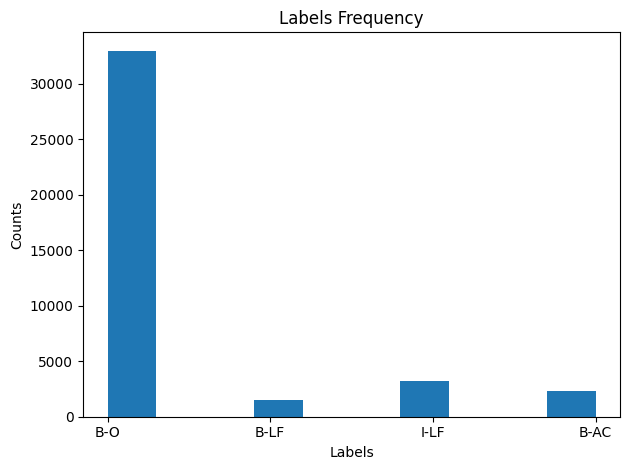

In [12]:
# getting the labels and plotting the histogram
plt.hist([y for seq in df_train["ner_tags"].to_numpy() for y in seq])
plt.title("Labels Frequency")
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.tight_layout()

### 1.2.2. Labels frequency pie chart

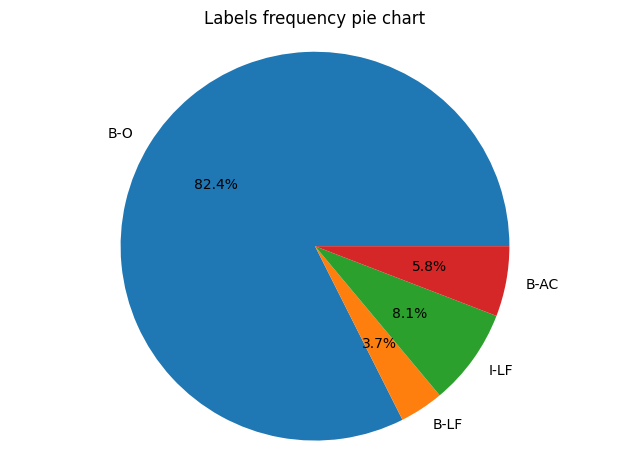

In [13]:
# getting the labels and their counts
labels_counts = Counter([y for seq in df_train["ner_tags"].to_numpy() for y in seq])
labels = list(labels_counts.keys())
counts = list(labels_counts.values())

# plotting the pie chart
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Labels frequency pie chart')
plt.axis('equal')
plt.tight_layout()

### 1.2.3. Labels correlation matrix

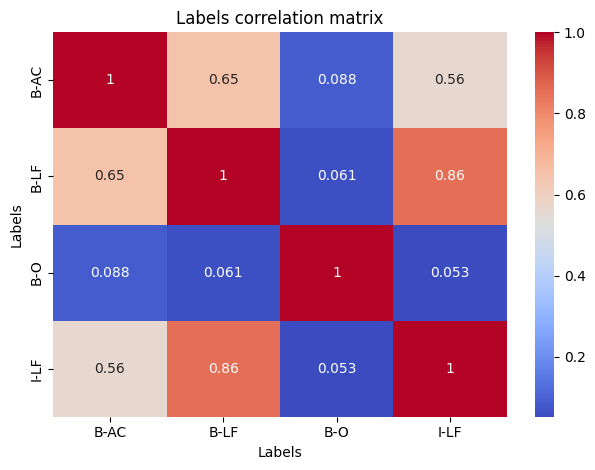

In [14]:
# getting unique labels
labels = sorted(set(np.concatenate(df_train['ner_tags'].values)))

# creating a binary matrix
binary_matrix = np.zeros((len(df_train)+1, len(labels)), dtype=int)
for idx, ner_tags_list in enumerate(df_train['ner_tags']):
  indices = np.array([labels.index(ner_tag) for ner_tag in ner_tags_list if ner_tag in labels])
  binary_matrix[idx, indices] = 1

# computing the correlation matrix
corr = np.corrcoef(binary_matrix.T)

# plotting the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.title('Labels correlation matrix')
plt.xlabel('Labels')
plt.ylabel('Labels')
plt.tight_layout()

### 1.2.4. Top 30 common tokens bar chart

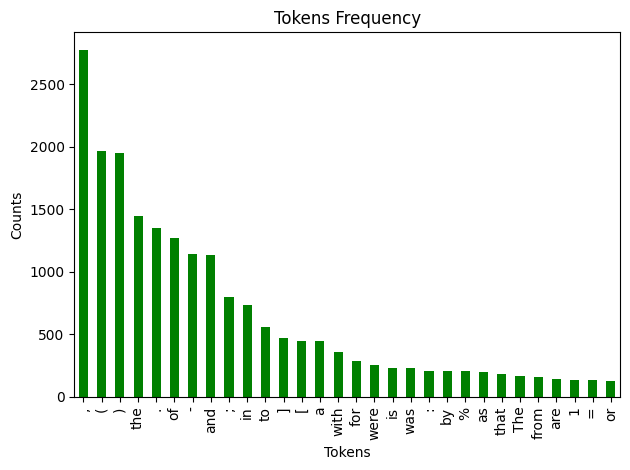

In [15]:
# getting the 30 most common words/tokens
df_tokens = pd.DataFrame({'tokens': [token for seq in corpus for token in seq]})
top_thirty_tokens = df_tokens['tokens'].value_counts()[:30]

# plotting the pie chart
top_thirty_tokens.plot(kind='bar', color='green')
plt.title("Tokens Frequency")
plt.xlabel("Tokens")
plt.ylabel("Counts")
plt.tight_layout()

### 1.2.5. Token sequences box plot

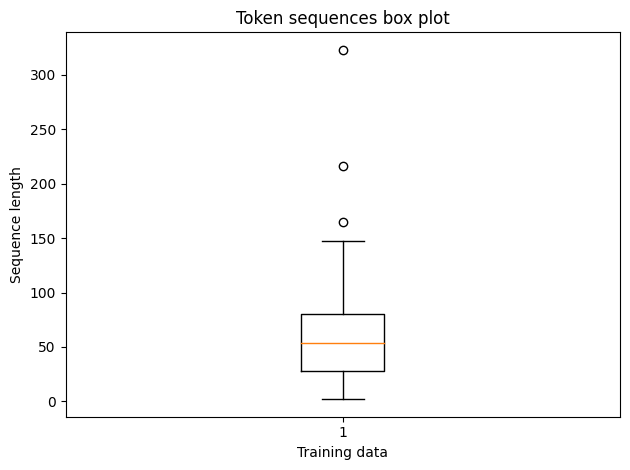

In [16]:
# getting the lengths of each sequence and plotting the box.
# this will also help to truncate our vectors as we'll have an idea of the average sequence length
plt.boxplot(df_train["tokens"].apply(lambda x: len(x)).unique())
plt.title("Token sequences box plot")
plt.xlabel("Training data")
plt.ylabel("Sequence length")
plt.tight_layout()

# 2. Experiments

## 2.1. Experiment 1 - Comparing features/vectorisation methods

### 2.1.1. Vectorisation

#### 2.1.1.1 Labels vectorization

In [17]:
# list to store all the labels
df_labels = []


def get_labels(cat_labels: list) -> None:
  """
  Stores categorical labels in the labels list.

  Parameters:
    x (list): the sequence's labels in each row.
  """
  for label in cat_labels:
    df_labels.append(label)


def cat2num(cat_labels: list, num_labels: dict) -> None:
  """
  Converts categorical labels to numerical.

  Parameters:
    cat_labels (list): The sequence's labels in each row.
    num_labels (dict): Label names and their respective values.
  """
  for idx, label in enumerate(cat_labels):
    cat_labels[idx] = num_labels[label]

In [18]:
# getting all labels
df_train["ner_tags"].apply(lambda x: get_labels(x))

# keeping unique labels
labels = dict.fromkeys(set(df_labels), 0)

# making sure we only have 4 labels
assert len(labels) == 4

# mapping labels to their numerical values
labels["B-O"] = 0
labels["B-AC"] = 1
labels["B-LF"] = 3
labels["I-LF"] = 4

# converting categorical labels to numerical
df_train["ner_tags"].apply(lambda x: cat2num(x, labels))
df_valid["ner_tags"].apply(lambda x: cat2num(x, labels))
df_test["ner_tags"].apply(lambda x: cat2num(x, labels))

# NOTE: please don't run this cell twice as changes to the dataframe will be applied after the assertion

0      None
1      None
2      None
3      None
4      None
       ... 
148    None
149    None
150    None
151    None
152    None
Name: ner_tags, Length: 153, dtype: object

In [19]:
# categorical classes were converted to numerical
df_train.head(10)

,tokens,pos_tags,ner_tags
0,"[For, this, purpose, the, Gothenburg, Young, P...","[ADP, DET, NOUN, DET, PROPN, PROPN, PROPN, PRO...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]"
1,"[The, following, physiological, traits, were, ...","[DET, ADJ, ADJ, NOUN, AUX, VERB, PUNCT, ADJ, N...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ..."
2,"[Minor, H, antigen, alloimmune, responses, rea...","[ADJ, PROPN, NOUN, ADJ, NOUN, ADV, VERB, ADP, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ..."
3,"[EPI, =, Echo, planar, imaging, .]","[PROPN, PUNCT, NOUN, NOUN, NOUN, PUNCT]","[1, 0, 3, 4, 4, 0]"
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[ADV, PUNCT, PROPN, PUNCT, VERB, PROPN, NOUN, ...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,"[The, importance, of, NO, and, the, formation,...","[PROPN, NOUN, ADP, PROPN, CCONJ, DET, NOUN, AD...","[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
6,"[These, findings, unveil, a, novel, NO, -, dep...","[DET, NOUN, VERB, DET, ADJ, PROPN, PUNCT, ADJ,...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,"[Both, Mekk3, cKO, and, their, wild, -, type, ...","[DET, PROPN, PROPN, CCONJ, PRON, ADJ, PUNCT, N...","[0, 0, 1, 0, 0, 3, 4, 4, 0, 1, 0, 0, 0, 0, 0, ..."
8,"[Recent, work, by, us, and, others, suggests, ...","[ADJ, NOUN, ADP, PRON, CCONJ, NOUN, VERB, SCON...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 4, ..."
9,"[We, performed, a, linear, regression, model, ...","[PRON, VERB, DET, ADJ, NOUN, NOUN, ADP, DET, N...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 4, 4, ..."


#### 2.1.1.2 Vectorisation techniques on our word/token sequences

In [20]:
import random
from gensim.models import Word2Vec, FastText
from sklearn.decomposition import PCA

In [21]:
def plot_word_embeddings(word_embedding_dict: dict, vectorization_method: str, sample_size: int=15) -> None:
  """
  Creating a scatter plot of word embeddings for a given vectorisation method. Random samples are plotted.

  Parameters:
    word_embedding_dict (dict): Dictionary containing words and their respective vectors.
    vectorization_method (str): The vectorization method used to generate the word embeddings.
    sample_size (int): The number of sample to be plotted.
  """
  # getting a random sample of word embeddings
  sample_words = random.sample(list(word_embedding_dict.keys()), sample_size)
  sample_embeddings = np.array([word_embedding_dict[word] for word in sample_words])

  # fitting word embeddings to the PCA model
  pca = PCA(n_components=2, random_state=42)
  sample_embeddings = pca.fit_transform(sample_embeddings)

  # plotting the scatter plot
  plt.figure(figsize=(8, 8))
  plt.scatter(sample_embeddings[:, 0], sample_embeddings[:, 1], marker='o', s=50, alpha=0.5)

  for i, word in enumerate(sample_words):
      plt.annotate(word, (sample_embeddings[i, 0], sample_embeddings[i, 1]))

  plt.title(f"A sample of {vectorization_method} word Embeddings")
  plt.xlabel("PCA 1D")
  plt.ylabel("PCA 2D")
  plt.grid(True)
  plt.tight_layout()

##### Word2vec word embeddings

In [22]:
# dictionary to store word2vec word embeddings
word2vec = dict.fromkeys(words, 0)

In [23]:
# training the Word2Vec model
word2vec_model = Word2Vec(
    corpus,
    min_count=1,
    workers=4
)
# assigning the tokens their respective vectors
for word in word2vec.keys():
  word2vec[word] = word2vec_model.wv[word]

In [24]:
# creating dataframes with the word embeddings generated to simplify the preparation of our vectors before feeding them into our models
df_train_word2vec = df_train.copy()
df_valid_word2vec = df_valid.copy()
df_test_word2vec = df_test.copy()

df_train_word2vec['tokens'] = df_train_word2vec['tokens'].apply(
    lambda tokens_arr: [word2vec[token] for token in tokens_arr]
)
df_valid_word2vec['tokens'] = df_valid_word2vec['tokens'].apply(
    lambda tokens_arr: [word2vec[token] for token in tokens_arr]
)
df_test_word2vec['tokens'] = df_test_word2vec['tokens'].apply(
    lambda tokens_arr: [word2vec[token] for token in tokens_arr]
)

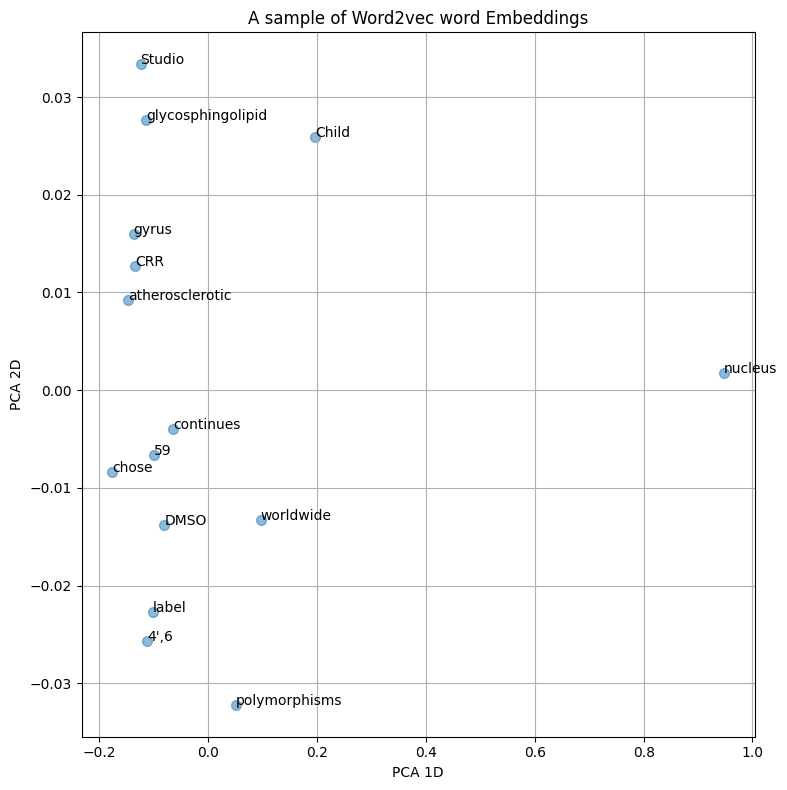

In [25]:
plot_word_embeddings(word2vec, 'Word2vec', 15)

##### FastText word embeddings

In [26]:
# dictionary to store FastText word embeddings
word2fasttext = dict.fromkeys(words, 0)

In [27]:
# training the FastText model
fasttext_model = FastText(
    corpus,
    min_count=1,
    workers=4
)
# assigning the tokens their respective vectors
for word in word2fasttext.keys():
  word2fasttext[word] = fasttext_model.wv[word]

In [28]:
# creating dataframes with the word embeddings generated to simplify the preparation of our vectors before feeding them into our models
df_train_word2fasttext = df_train.copy()
df_valid_word2fasttext = df_valid.copy()
df_test_word2fasttext = df_test.copy()

df_train_word2fasttext['tokens'] = df_train_word2fasttext['tokens'].apply(
    lambda tokens_arr: [word2fasttext[token] for token in tokens_arr]
)
df_valid_word2fasttext['tokens'] = df_valid_word2fasttext['tokens'].apply(
    lambda tokens_arr: [word2fasttext[token] for token in tokens_arr]
)
df_test_word2fasttext['tokens'] = df_test_word2fasttext['tokens'].apply(
    lambda tokens_arr: [word2fasttext[token] for token in tokens_arr]
)

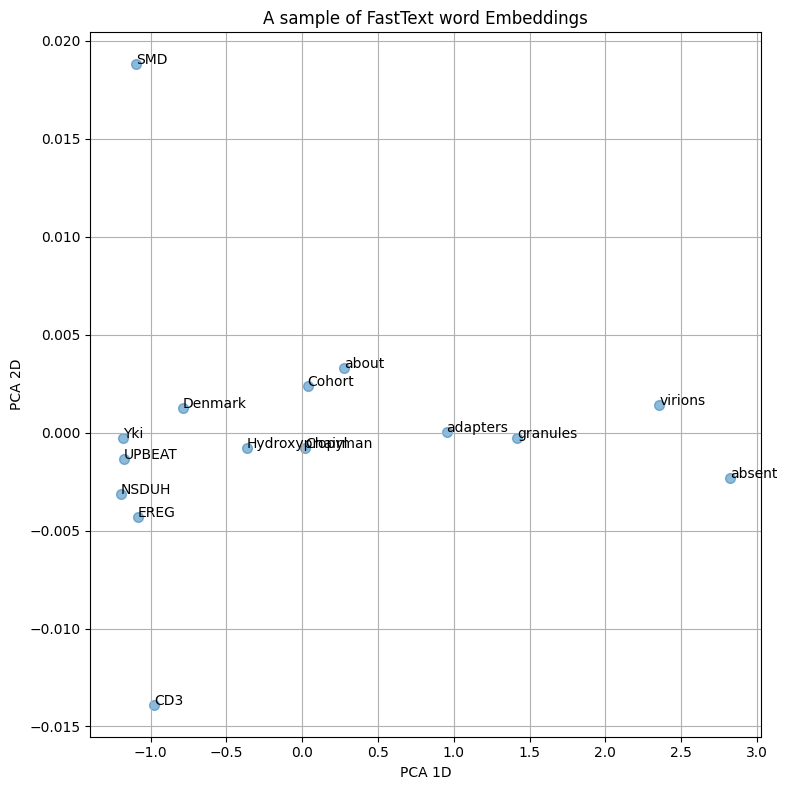

In [29]:
plot_word_embeddings(word2fasttext, 'FastText', 15)

##### Word2index vectorisation

In [30]:
from keras.preprocessing.text import Tokenizer

In [31]:
# using the keras tokenizer to assign a unique index to each token in our data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tokens'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

max_seq_length = max(len(seq) for seq in df['tokens'])
X_word2idx = tokenizer.texts_to_sequences(df['tokens'])

In [32]:
# slicing the indices array appropriately to format the dataframes intended for vectors preparation
df_train_length = len(df_train)
df_valid_length = len(df_valid)
df_test_length = len(df_test)

df_train_word2idx = df_train.copy()
df_valid_word2idx = df_valid.copy()
df_test_word2idx = df_test.copy()

df_train_word2idx["tokens"] = X_word2idx[:df_train_length]
df_valid_word2idx["tokens"] = X_word2idx[df_train_length:df_train_length+df_valid_length]
df_test_word2idx["tokens"] = X_word2idx[df_train_length+df_valid_length:df_train_length+ \
                                        df_valid_length+df_test_length]

#### 2.1.1.3 Padding and truncating vectors

In [33]:
# padding vectors and trucating them to the average sequence length. The length computed will be similar to the average length visualised earlier in the box plot
max_seq_length = math.ceil(df_train["tokens"].apply(lambda x: len(x)).unique().mean())
vocab_size = len(words)

In [34]:
from keras.preprocessing.sequence import pad_sequences

In [35]:
def generate_feature_vectors(df: pd.DataFrame) -> np.ndarray:
  """
  Padding and truncating feature vectors. The resulting feature vectors can be fed into our models.

  Parameters:
    df (pd.DataFrame): The dataframe with the word embeddings.
  Returns:
    np.ndarray: The feature vectors.
  """
  X = pad_sequences(
    df["tokens"],
    maxlen=max_seq_length,
    padding='post',
    value=vocab_size-1,
    dtype='float32'
  )
  return X

##### Word2vec feature vectors

In [36]:
X_train_word2vec = generate_feature_vectors(df_train_word2vec)
X_valid_word2vec = generate_feature_vectors(df_valid_word2vec)
X_test_word2vec = generate_feature_vectors(df_test_word2vec)

##### FastText feature vectors

In [37]:
X_train_word2fasttext = generate_feature_vectors(df_train_word2fasttext)
X_valid_word2fasttext = generate_feature_vectors(df_valid_word2fasttext)
X_test_word2fasttext = generate_feature_vectors(df_test_word2fasttext)

##### Word2index feature vectors

In [38]:
X_train_word2idx = generate_feature_vectors(df_train_word2idx)
X_valid_word2idx = generate_feature_vectors(df_valid_word2idx)
X_test_word2idx = generate_feature_vectors(df_test_word2idx)

##### Label vectors

In [39]:
# The true labels remain the same irrespective of the feature vectorisation method used to train our models
y_train = pad_sequences(df_train['ner_tags'], maxlen=max_seq_length, padding='post', value=5)
y_valid = pad_sequences(df_valid['ner_tags'], maxlen=max_seq_length, padding='post', value=5)
y_test = pad_sequences(df_test['ner_tags'], maxlen=max_seq_length, padding='post', value=5)

### 2.1.2. Algorithms

#### 2.1.2.1 Defining Models

In [40]:
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Embedding, LSTM, Bidirectional, Input
from keras.src.callbacks import History

##### Defining the CNN model

In [41]:
class CNN:
  def __init__(self, max_seq_length: int, embedding_dim: int=100, custom_word_embedding: bool=False, vocab_size: int=-1):
    """
    Initialising the CNN model.

    Parameters:
      max_seq_length (int): The maximum length of a sequence.
      embedding_dim (int): The word embedding dimension.
      custom_word_embedding (bool): Indicator to know whether a custom word embedding technique is being used.
      vocab_size (int): The number of unique tokens in the data fed into the model.
    """
    self.custom_word_embedding = custom_word_embedding
    self.embedding_dim = embedding_dim
    if custom_word_embedding:
      self.input_shape = (max_seq_length, embedding_dim)
    else:
      self.input_shape = max_seq_length
      self.vocab_size = vocab_size

    self._build()

  def _build(self) -> None:
    """
    Building the model. An embedding layer is added to the model if no custom word embedding is used.
    """
    self.cnn_model = Sequential()
    if not self.custom_word_embedding:
      self.cnn_model.add(Embedding(self.vocab_size, self.embedding_dim, input_length=self.input_shape))
    self.cnn_model.add(Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same', input_shape=self.input_shape))
    self.cnn_model.add(Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same', input_shape=self.input_shape))
    self.cnn_model.add(Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same', input_shape=self.input_shape))
    self.cnn_model.add(Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same', input_shape=self.input_shape))
    self.cnn_model.add(Dense(6, activation='softmax'))

    self.cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    self.cnn_model.summary()

  def fit(self, x: np.ndarray, y: np.ndarray, validation_data: tuple[np.ndarray, np.ndarray], epochs: int, batch_size: int) -> History:
    """
    Training the model.

    Parameters:
      x (np.ndarray): Features array.
      y (np.ndarray): Labels array.
      validation_data (tuple[np.ndarray, np.ndarray]): A tuple containing validation feature and label arrays.
      epochs (int): The number of epochs set for the model training.
      batch_size (int): The batch of data used for training the model.
    Returns:
      History: The model training history.
    """
    history = self.cnn_model.fit(x=x, y=y, validation_data=validation_data, epochs=epochs, batch_size=batch_size)
    return history

  def predict(self, x: np.ndarray) -> np.ndarray:
    """
    Making predictions and converting predicted probabilities to predicted labels.

    Parameters:
      x (np.ndarray): Unseen/test data.
    Returns:
      np.ndarray: Predicted labels.
    """
    predictions = self.cnn_model.predict(x)
    return np.argmax(predictions, axis=-1)

##### Defining the RNN (LSTM) model

In [42]:
class RNN:
  def __init__(self, max_seq_length: int, embedding_dim: int=100, custom_word_embedding: bool=False, vocab_size: int=-1):
    """
    Initialising the RNN (LSTM) model.

    Parameters:
      max_seq_length (int): The maximum length of a sequence.
      embedding_dim (int): The word embedding dimension.
      custom_word_embedding (bool): Indicator to know whether a custom word embedding technique is being used.
      vocab_size (int): The number of unique tokens in the data fed into the model.
    """
    self.custom_word_embedding = custom_word_embedding
    self.embedding_dim = embedding_dim
    if custom_word_embedding:
      self.input_shape = (max_seq_length, self.embedding_dim)
    else:
      self.input_shape = max_seq_length
      self.vocab_size = vocab_size

    self._build()

  def _build(self) -> None:
    """
    Building the model. An embedding layer is added to the model if no custom word embedding is used.
    """
    self.rnn_model = Sequential()
    if not self.custom_word_embedding:
      self.rnn_model.add(Embedding(self.vocab_size, self.embedding_dim, input_length=self.input_shape))
    else:
      self.rnn_model.add(Input(shape=self.input_shape))
    self.rnn_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    self.rnn_model.add(Dense(6, activation='softmax'))

    self.rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    self.rnn_model.summary()

  def fit(self, x: np.ndarray, y: np.ndarray, validation_data: tuple[np.ndarray, np.ndarray], epochs: int, batch_size: int) -> History:
    """
    Training the model.

    Parameters:
      x (np.ndarray): Features array.
      y (np.ndarray): Labels array.
      validation_data (tuple[np.ndarray, np.ndarray]): A tuple containing validation feature and label arrays.
      epochs (int): The number of epochs set for the model training.
      batch_size (int): The batch of data used for training the model.
    Returns:
      History: The model training history.
    """
    history = self.rnn_model.fit(x=x, y=y, validation_data=validation_data, epochs=epochs, batch_size=batch_size)
    return history

  def predict(self, x: np.ndarray) -> np.ndarray:
    """
    Making predictions and converting predicted probabilities to predicted labels.

    Parameters:
      x (np.ndarray): Unseen/test data.
    Returns:
      np.ndarray: Predicted labels.
    """
    predictions = self.rnn_model.predict(x)
    return np.argmax(predictions, axis=-1)

##### Defining the FFNN model

In [43]:
class FFNN:
  def __init__(self, max_seq_length: int, embedding_dim: int=100, custom_word_embedding: bool=False, vocab_size: int=-1):
    """
    Initialising the FFNN model.

    Parameters:
      max_seq_length (int): The maximum length of a sequence.
      embedding_dim (int): The word embedding dimension.
      custom_word_embedding (bool): Indicator to know whether a custom word embedding technique is being used.
      vocab_size (int): The number of unique tokens in the data fed into the model.
    """
    self.custom_word_embedding = custom_word_embedding
    self.embedding_dim = embedding_dim
    if custom_word_embedding:
      self.input_shape = (max_seq_length, self.embedding_dim)
    else:
      self.input_shape = max_seq_length
      self.vocab_size = vocab_size

    self._build()

  def _build(self) -> None:
    """
    Building the model. An embedding layer is added to the model if no custom word embedding is used.
    """
    self.ffnn_model = Sequential()
    if not self.custom_word_embedding:
      self.ffnn_model.add(Embedding(self.vocab_size, self.embedding_dim, input_length=self.input_shape))
    else:
      self.ffnn_model.add(Input(shape=self.input_shape))
    self.ffnn_model.add(Dense(128, activation="relu"))
    self.ffnn_model.add(Dense(64, activation="relu"))
    self.ffnn_model.add(Dense(32, activation="relu"))
    self.ffnn_model.add(Dense(16, activation="relu"))
    self.ffnn_model.add(Dense(6, activation='softmax'))

    self.ffnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    self.ffnn_model.summary()

  def fit(self, x: np.ndarray, y: np.ndarray, validation_data: tuple[np.ndarray, np.ndarray], epochs: int, batch_size: int) -> History:
    """
    Training the model.

    Parameters:
      x (np.ndarray): Features array.
      y (np.ndarray): Labels array.
      validation_data (tuple[np.ndarray, np.ndarray]): A tuple containing validation feature and label arrays.
      epochs (int): The number of epochs set for the model training.
      batch_size (int): The batch of data used for training the model.
    Returns:
      History: The model training history.
    """
    history = self.ffnn_model.fit(x=x, y=y, validation_data=validation_data, epochs=epochs, batch_size=batch_size)
    return history

  def predict(self, x: np.ndarray) -> np.ndarray:
    """
    Making predictions and converting predicted probabilities to predicted labels.

    Parameters:
      x (np.ndarray): Unseen/test data.
    Returns:
      np.ndarray: Predicted labels.
    """
    predictions = self.ffnn_model.predict(x)
    return np.argmax(predictions, axis=-1)

#### 2.1.2.2 Testing different vectorisation methods on one model - RNN (LSTM)

##### Building the same RNN model for each vectorisation method

In [44]:
rnn_word2vec = RNN(max_seq_length=max_seq_length, embedding_dim=100, custom_word_embedding=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 60, 512)           731136    
 al)                                                             
                                                                 
 dense (Dense)               (None, 60, 6)             3078      
                                                                 
Total params: 734214 (2.80 MB)
Trainable params: 734214 (2.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
rnn_fasttext = RNN(max_seq_length=max_seq_length, embedding_dim=100, custom_word_embedding=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 60, 512)           731136    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 60, 6)             3078      
                                                                 
Total params: 734214 (2.80 MB)
Trainable params: 734214 (2.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
rnn_word2idx = RNN(max_seq_length=max_seq_length, embedding_dim=100, vocab_size=vocab_size, custom_word_embedding=False)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           1058900   
                                                                 
 bidirectional_2 (Bidirecti  (None, 60, 512)           731136    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 60, 6)             3078      
                                                                 
Total params: 1793114 (6.84 MB)
Trainable params: 1793114 (6.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Training the models with different types of vectors

In [47]:
def plot_training_loss(history: History, model_name: str) -> None:
  """
  Plotting the model training loss.

  Parameters:
    history (History): The training history of a model.
    model_name (str): The trained model name.
  """
  print('Training loss:' + '\n==============\n')

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(f'{model_name} loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['training', 'validation'], loc='upper right')

In [48]:
word2vec_history = rnn_word2vec.fit(
    X_train_word2vec,
    y_train,
    validation_data=(X_valid_word2vec, y_valid),
    epochs=10,
    batch_size=32
)

Epoch 1/10
34/34 [==============================] - 20s 423ms/step - loss: 0.5416 - accuracy: 0.8517 - val_loss: 0.3011 - val_accuracy: 0.9115
Epoch 2/10
34/34 [==============================] - 14s 402ms/step - loss: 0.3146 - accuracy: 0.8960 - val_loss: 0.2829 - val_accuracy: 0.9115
Epoch 3/10
34/34 [==============================] - 13s 394ms/step - loss: 0.2894 - accuracy: 0.8972 - val_loss: 0.2670 - val_accuracy: 0.9138
Epoch 4/10
34/34 [==============================] - 13s 397ms/step - loss: 0.2722 - accuracy: 0.9016 - val_loss: 0.2671 - val_accuracy: 0.9192
Epoch 5/10
34/34 [==============================] - 14s 404ms/step - loss: 0.2536 - accuracy: 0.9096 - val_loss: 0.2530 - val_accuracy: 0.9196
Epoch 6/10
34/34 [==============================] - 14s 400ms/step - loss: 0.2503 - accuracy: 0.9104 - val_loss: 0.2416 - val_accuracy: 0.9233
Epoch 7/10
34/34 [==============================] - 14s 409ms/step - loss: 0.2384 - accuracy: 0.9158 - val_loss: 0.2392 - val_accuracy: 0.9201

Training loss:



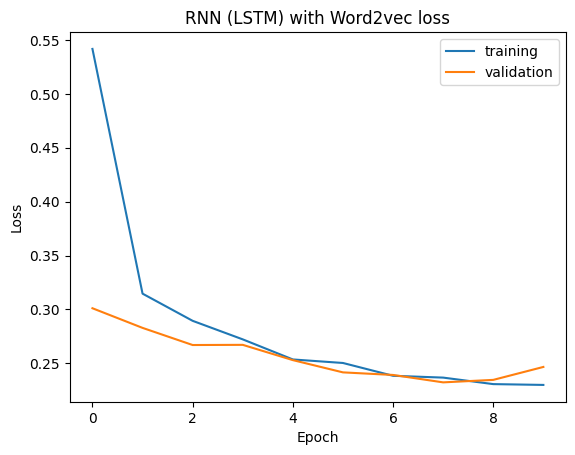

In [49]:
plot_training_loss(word2vec_history, 'RNN (LSTM) with Word2vec')

In [50]:
fasttext_history = rnn_fasttext.fit(
    X_train_word2fasttext,
    y_train,
    validation_data=(X_valid_word2fasttext, y_valid),
    epochs=10,
    batch_size=32
)

Epoch 1/10
34/34 [==============================] - 19s 437ms/step - loss: 0.4884 - accuracy: 0.8593 - val_loss: 0.2843 - val_accuracy: 0.9115
Epoch 2/10
34/34 [==============================] - 14s 399ms/step - loss: 0.3025 - accuracy: 0.9016 - val_loss: 0.2608 - val_accuracy: 0.9177
Epoch 3/10
34/34 [==============================] - 13s 399ms/step - loss: 0.2738 - accuracy: 0.9072 - val_loss: 0.2365 - val_accuracy: 0.9200
Epoch 4/10
34/34 [==============================] - 14s 402ms/step - loss: 0.2426 - accuracy: 0.9094 - val_loss: 0.2279 - val_accuracy: 0.9242
Epoch 5/10
34/34 [==============================] - 14s 409ms/step - loss: 0.2192 - accuracy: 0.9194 - val_loss: 0.2074 - val_accuracy: 0.9249
Epoch 6/10
34/34 [==============================] - 13s 391ms/step - loss: 0.2084 - accuracy: 0.9237 - val_loss: 0.2046 - val_accuracy: 0.9266
Epoch 7/10
34/34 [==============================] - 14s 414ms/step - loss: 0.2055 - accuracy: 0.9245 - val_loss: 0.1982 - val_accuracy: 0.9261

Training loss:



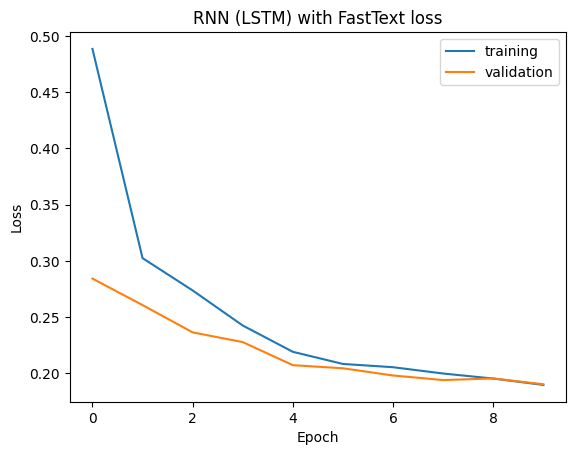

In [51]:
plot_training_loss(fasttext_history, 'RNN (LSTM) with FastText')

In [52]:
word2idx_history = rnn_word2idx.fit(
    X_train_word2idx,
    y_train,
    validation_data=(X_valid_word2idx, y_valid),
    epochs=10,
    batch_size=32
)

Epoch 1/10
34/34 [==============================] - 22s 535ms/step - loss: 0.8095 - accuracy: 0.7741 - val_loss: 0.4397 - val_accuracy: 0.9007
Epoch 2/10
34/34 [==============================] - 16s 471ms/step - loss: 0.4129 - accuracy: 0.8923 - val_loss: 0.3628 - val_accuracy: 0.9107
Epoch 3/10
34/34 [==============================] - 16s 471ms/step - loss: 0.3698 - accuracy: 0.8942 - val_loss: 0.3384 - val_accuracy: 0.9098
Epoch 4/10
34/34 [==============================] - 16s 486ms/step - loss: 0.3161 - accuracy: 0.8972 - val_loss: 0.3010 - val_accuracy: 0.9130
Epoch 5/10
34/34 [==============================] - 18s 527ms/step - loss: 0.2299 - accuracy: 0.9169 - val_loss: 0.2527 - val_accuracy: 0.9180
Epoch 6/10
34/34 [==============================] - 17s 504ms/step - loss: 0.1545 - accuracy: 0.9481 - val_loss: 0.2316 - val_accuracy: 0.9221
Epoch 7/10
34/34 [==============================] - 17s 503ms/step - loss: 0.1094 - accuracy: 0.9640 - val_loss: 0.2473 - val_accuracy: 0.9235

Training loss:



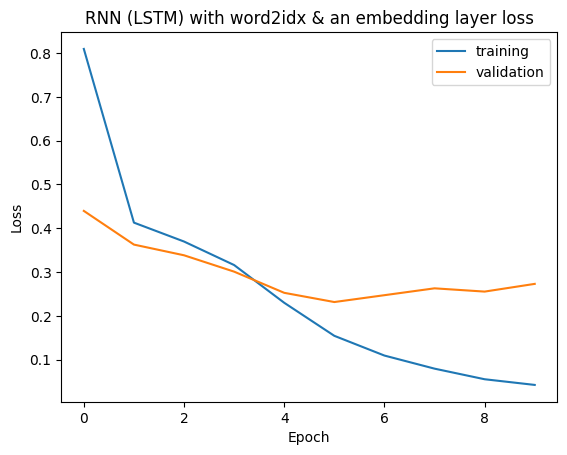

In [53]:
plot_training_loss(word2idx_history, 'RNN (LSTM) with word2idx & an embedding layer')

##### Making predictions on the unseen data and evaluating the performance

In [54]:
from seqeval.metrics import classification_report, f1_score, accuracy_score

In [55]:
def remove_paddings(x: list, pad_value: int) -> list:
  """
  Removing padding values from a 2D list.

  Parameters:
    x (list): 2D list with padding values.
    pad_value (int): The padding value to be removed.
  Returns:
    list: A clean list without padding values.
  """
  for seq in x:
    if pad_value in seq:
      while pad_value in seq:
        seq.remove(5)
  return x

In [56]:
def evaluate_model_performance(y_true: np.ndarray, y_pred: np.ndarray) -> None:
  """
  Evaluating a model performance. The metrics used are accuracy, precision, recall, and f1-score. A confusion matrix is also ploted

  Parameters:
    y_true (np.ndarray): The actual data labels.
    y_pred (np.ndarray): The labels predicted by the model.
  """
  y_true_list = y_true.tolist()
  y_pred_list = y_pred.tolist()
  y_true_flat = y_true.flatten()
  y_pred_flat = y_pred.flatten()

  classes_mapping = {0: "B-O", 1: "B-AC", 3: "B-LF", 4: "I-LF"}

  # 1. classification report & overall score - f1-score, precision, recall, support (number of class occurences), and accuracy
  # removing the padding value
  y_true_list = remove_paddings(y_true_list, 5)
  y_pred_list = remove_paddings(y_pred_list, 5)

  # converting numerical classes back to categorical
  y_true_cat = [[classes_mapping[y] for y in seq] for seq in y_true_list]
  y_pred_cat = [[classes_mapping[y] for y in seq] for seq in y_pred_list]

  # 2. confusion matrix - Labels predictions are shown to have an insight into our model predictions
  # removing the padding value
  mask_paddings = y_true_flat != 5
  y_true_flat = y_true_flat[mask_paddings]
  y_pred_flat = y_pred_flat[mask_paddings]

  # converting numerical classes back to categorical
  y_true_flat = [classes_mapping[y] for y in y_true_flat]
  y_pred_flat = [classes_mapping[y] for y in y_pred_flat]

  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

  cat_labels = sorted(['B-O', 'B-AC', 'B-LF', 'I-LF'])
  confusion_matrix = confusion_matrix(y_true_flat, y_pred_flat)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=cat_labels)
  custom_cmap = plt.cm.coolwarm

  print('Overall score:' + '\n==============\n')
  print(f'\tf1-score\t{round(f1_score(y_true_cat, y_pred_cat), 2)}\n\taccuracy\t{round(accuracy_score(y_true_cat, y_pred_cat), 2)}\n\n')

  print('Classification report:' + '\n======================\n')
  print(classification_report(y_true_cat, y_pred_cat) + "\n")

  print('Confusion matrix:' + '\n=================\n')
  cm_display.plot(cmap=custom_cmap)

In [57]:
word2vec_pred = rnn_word2vec.predict(X_test_word2vec)
fasttext_pred = rnn_fasttext.predict(X_test_word2fasttext)
word2idx_pred = rnn_word2idx.predict(X_test_word2idx)

5/5 [==============================] - 1s 99ms/step


Word2vec


Overall score:

	f1-score	0.88
	accuracy	0.86


Classification report:

              precision    recall  f1-score   support

          AC       0.55      0.42      0.47       265
          LF       0.25      0.30      0.27       148
           O       0.92      0.94      0.93      4148

   micro avg       0.88      0.89      0.88      4561
   macro avg       0.57      0.55      0.56      4561
weighted avg       0.87      0.89      0.88      4561


Confusion matrix:



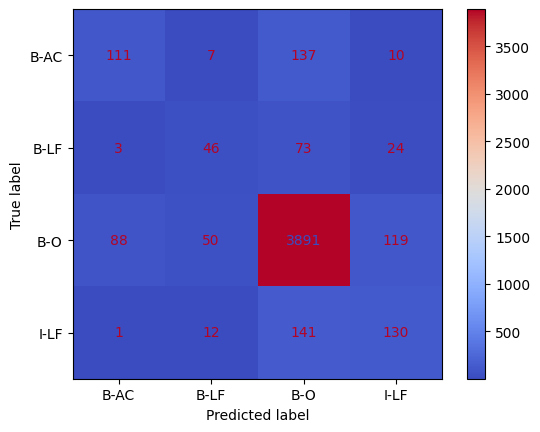

In [58]:
print('Word2vec\n\n')
evaluate_model_performance(y_test, word2vec_pred)

FastText


Overall score:

	f1-score	0.9
	accuracy	0.88


Classification report:

              precision    recall  f1-score   support

          AC       0.62      0.56      0.59       265
          LF       0.30      0.30      0.30       148
           O       0.92      0.95      0.94      4148

   micro avg       0.89      0.90      0.90      4561
   macro avg       0.61      0.60      0.61      4561
weighted avg       0.89      0.90      0.89      4561


Confusion matrix:



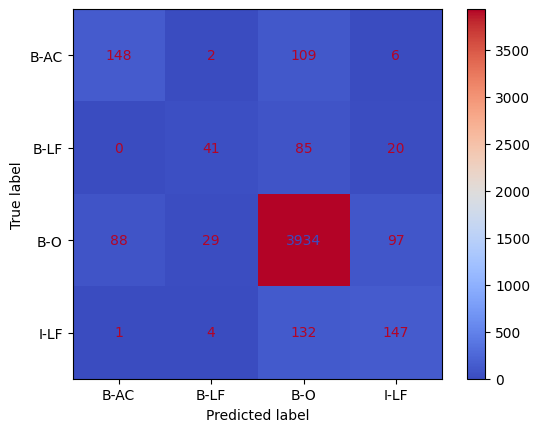

In [59]:
print('FastText\n\n')
evaluate_model_performance(y_test, fasttext_pred)

Word2idx


Overall score:

	f1-score	0.87
	accuracy	0.86


Classification report:

              precision    recall  f1-score   support

          AC       0.48      0.36      0.41       265
          LF       0.21      0.24      0.22       148
           O       0.91      0.94      0.92      4148

   micro avg       0.87      0.88      0.87      4561
   macro avg       0.53      0.51      0.52      4561
weighted avg       0.86      0.88      0.87      4561


Confusion matrix:



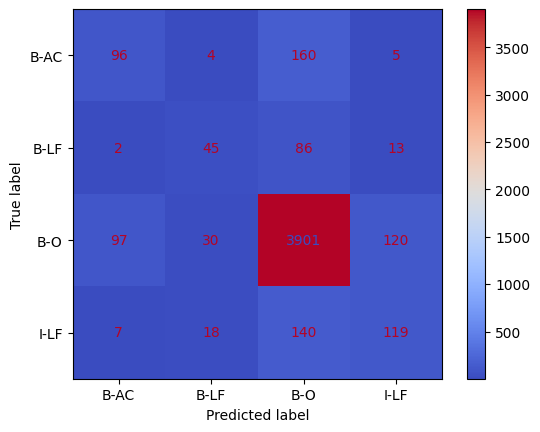

In [60]:
print('Word2idx\n\n')
evaluate_model_performance(y_test, word2idx_pred)

## 2.2. Experiment 2 - Comparing algorithms

### 2.2.1. CNN

#### 2.2.1.1. Building and training model

In [61]:
cnn = CNN(max_seq_length=max_seq_length, embedding_dim=100, custom_word_embedding=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 128)           38528     
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 128)           49280     
                                                                 
 conv1d_2 (Conv1D)           (None, 60, 128)           49280     
                                                                 
 conv1d_3 (Conv1D)           (None, 60, 128)           49280     
                                                                 
 dense_3 (Dense)             (None, 60, 6)             774       
                                                                 
Total params: 187142 (731.02 KB)
Trainable params: 187142 (731.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
cnn_history = cnn.fit(
    X_train_word2fasttext,
    y_train,
    validation_data=(X_valid_word2fasttext, y_valid),
    epochs=10,
    batch_size=32
)

Epoch 1/10
34/34 [==============================] - 5s 102ms/step - loss: 105.3312 - accuracy: 0.8455 - val_loss: 4.8268 - val_accuracy: 0.9009
Epoch 2/10
34/34 [==============================] - 2s 55ms/step - loss: 6.4386 - accuracy: 0.8958 - val_loss: 9.2762 - val_accuracy: 0.9160
Epoch 3/10
34/34 [==============================] - 2s 56ms/step - loss: 5.3522 - accuracy: 0.9026 - val_loss: 2.6597 - val_accuracy: 0.9230
Epoch 4/10
34/34 [==============================] - 2s 57ms/step - loss: 2.6687 - accuracy: 0.9061 - val_loss: 2.1851 - val_accuracy: 0.9229
Epoch 5/10
34/34 [==============================] - 2s 55ms/step - loss: 2.2124 - accuracy: 0.9116 - val_loss: 2.3282 - val_accuracy: 0.9290
Epoch 6/10
34/34 [==============================] - 2s 56ms/step - loss: 1.9406 - accuracy: 0.9150 - val_loss: 1.9785 - val_accuracy: 0.9272
Epoch 7/10
34/34 [==============================] - 3s 85ms/step - loss: 2.1568 - accuracy: 0.9130 - val_loss: 2.1595 - val_accuracy: 0.9275
Epoch 8/10

Training loss:



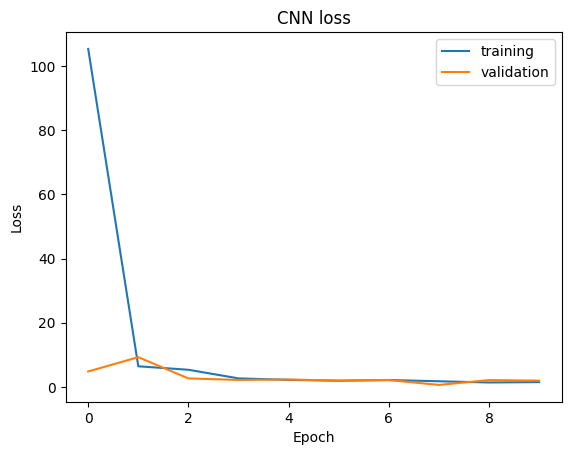

In [63]:
plot_training_loss(cnn_history, 'CNN')

#### 2.2.1.2. Predictions and evaluation

In [64]:
cnn_pred = cnn.predict(X_test_word2fasttext)

5/5 [==============================] - 0s 17ms/step


CNN evaluation:


Overall score:

	f1-score	0.88
	accuracy	0.87


Classification report:

              precision    recall  f1-score   support

          AC       0.79      0.26      0.39       265
          LF       0.10      0.14      0.11       148
           O       0.90      0.96      0.93      4148

   micro avg       0.86      0.90      0.88      4561
   macro avg       0.60      0.45      0.48      4561
weighted avg       0.86      0.90      0.87      4561


Confusion matrix:



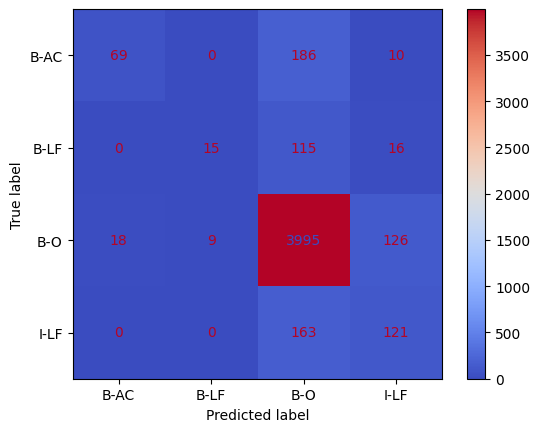

In [65]:
print('CNN evaluation:\n\n')
evaluate_model_performance(y_test, cnn_pred)

### 2.2.2. RNN (LSTM)

#### 2.2.2.1. Building and training model

In [66]:
rnn = RNN(max_seq_length=max_seq_length, embedding_dim=100, custom_word_embedding=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 60, 512)           731136    
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 60, 6)             3078      
                                                                 
Total params: 734214 (2.80 MB)
Trainable params: 734214 (2.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
rnn_history = rnn.fit(
    X_train_word2fasttext,
    y_train,
    validation_data=(X_valid_word2fasttext, y_valid),
    epochs=10,
    batch_size=32
)

Epoch 1/10
34/34 [==============================] - 20s 462ms/step - loss: 0.4822 - accuracy: 0.8596 - val_loss: 0.2897 - val_accuracy: 0.9122
Epoch 2/10
34/34 [==============================] - 14s 424ms/step - loss: 0.2953 - accuracy: 0.9019 - val_loss: 0.2545 - val_accuracy: 0.9213
Epoch 3/10
34/34 [==============================] - 15s 436ms/step - loss: 0.2660 - accuracy: 0.9067 - val_loss: 0.2343 - val_accuracy: 0.9231
Epoch 4/10
34/34 [==============================] - 15s 434ms/step - loss: 0.2372 - accuracy: 0.9129 - val_loss: 0.2156 - val_accuracy: 0.9262
Epoch 5/10
34/34 [==============================] - 15s 456ms/step - loss: 0.2175 - accuracy: 0.9202 - val_loss: 0.2096 - val_accuracy: 0.9213
Epoch 6/10
34/34 [==============================] - 15s 451ms/step - loss: 0.2065 - accuracy: 0.9248 - val_loss: 0.1957 - val_accuracy: 0.9298
Epoch 7/10
34/34 [==============================] - 15s 432ms/step - loss: 0.1998 - accuracy: 0.9271 - val_loss: 0.1939 - val_accuracy: 0.9295

Training loss:



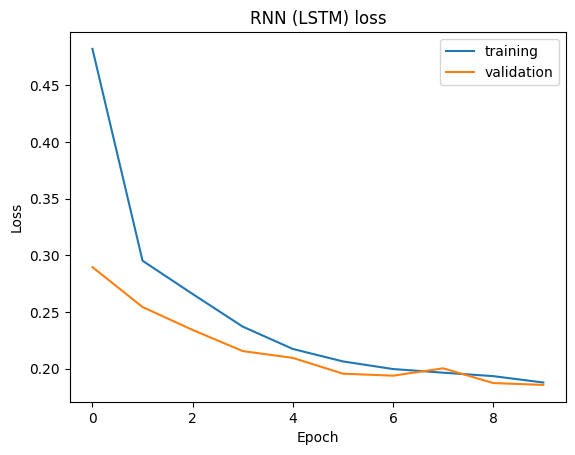

In [68]:
plot_training_loss(rnn_history, 'RNN (LSTM)')

#### 2.2.2.2. Predictions and evaluation

In [69]:
rnn_pred = rnn.predict(X_test_word2fasttext)

5/5 [==============================] - 1s 105ms/step


RNN (LSTM) evaluation:


Overall score:

	f1-score	0.9
	accuracy	0.89


Classification report:

              precision    recall  f1-score   support

          AC       0.62      0.60      0.61       265
          LF       0.36      0.29      0.32       148
           O       0.92      0.96      0.94      4148

   micro avg       0.89      0.91      0.90      4561
   macro avg       0.63      0.61      0.62      4561
weighted avg       0.88      0.91      0.90      4561


Confusion matrix:



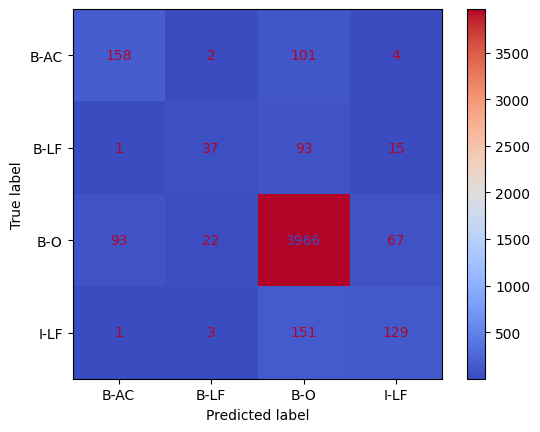

In [70]:
print('RNN (LSTM) evaluation:\n\n')
evaluate_model_performance(y_test, rnn_pred)

### 2.2.3. FFNN

#### 2.2.3.1. Building and training model

In [71]:
ffnn = FFNN(max_seq_length=max_seq_length, embedding_dim=100, custom_word_embedding=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 60, 128)           12928     
                                                                 
 dense_6 (Dense)             (None, 60, 64)            8256      
                                                                 
 dense_7 (Dense)             (None, 60, 32)            2080      
                                                                 
 dense_8 (Dense)             (None, 60, 16)            528       
                                                                 
 dense_9 (Dense)             (None, 60, 6)             102       
                                                                 
Total params: 23894 (93.34 KB)
Trainable params: 23894 (93.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [72]:
ffnn_history = ffnn.fit(
    X_train_word2fasttext,
    y_train,
    validation_data=(X_valid_word2fasttext, y_valid),
    epochs=10,
    batch_size=32
)

Epoch 1/10
34/34 [==============================] - 3s 36ms/step - loss: 8.0253 - accuracy: 0.8622 - val_loss: 0.4345 - val_accuracy: 0.9115
Epoch 2/10
34/34 [==============================] - 0s 14ms/step - loss: 0.3987 - accuracy: 0.8961 - val_loss: 0.3209 - val_accuracy: 0.9115
Epoch 3/10
34/34 [==============================] - 0s 13ms/step - loss: 0.6262 - accuracy: 0.8831 - val_loss: 0.3019 - val_accuracy: 0.9115
Epoch 4/10
34/34 [==============================] - 0s 13ms/step - loss: 0.3313 - accuracy: 0.8961 - val_loss: 0.2921 - val_accuracy: 0.9115
Epoch 5/10
34/34 [==============================] - 0s 14ms/step - loss: 0.3185 - accuracy: 0.8961 - val_loss: 0.2837 - val_accuracy: 0.9115
Epoch 6/10
34/34 [==============================] - 0s 13ms/step - loss: 0.3078 - accuracy: 0.8961 - val_loss: 0.2756 - val_accuracy: 0.9115
Epoch 7/10
34/34 [==============================] - 0s 13ms/step - loss: 0.2995 - accuracy: 0.8962 - val_loss: 0.2660 - val_accuracy: 0.9116
Epoch 8/10
34

Training loss:



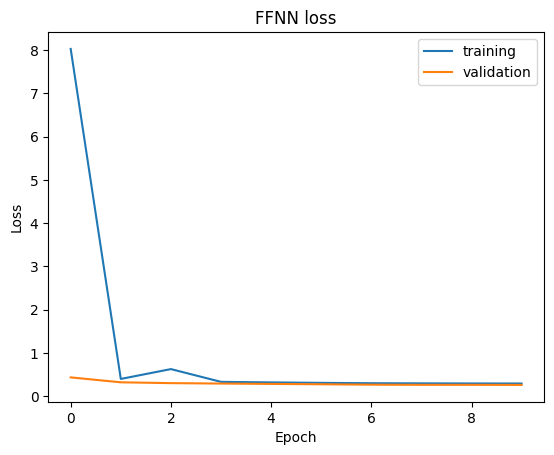

In [73]:
plot_training_loss(ffnn_history, 'FFNN')

#### 2.2.3.2. Predictions and evaluation

In [74]:
ffnn_pred = ffnn.predict(X_test_word2fasttext)

5/5 [==============================] - 0s 6ms/step


FFNN evaluation:


Overall score:

	f1-score	0.87
	accuracy	0.85


Classification report:

              precision    recall  f1-score   support

          AC       0.44      0.63      0.52       265
          LF       0.00      0.00      0.00       148
           O       0.88      0.95      0.92      4148

   micro avg       0.85      0.90      0.87      4561
   macro avg       0.44      0.53      0.48      4561
weighted avg       0.83      0.90      0.86      4561


Confusion matrix:



/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


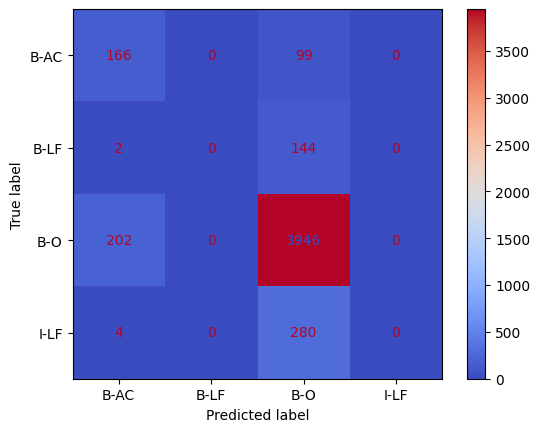

In [75]:
print('FFNN evaluation:\n\n')
evaluate_model_performance(y_test, ffnn_pred)

## 2.3. Experiment 3 - Hyperparameter optimisation

### 2.3.1. Learning rate

#### 2.3.1.1 Changing the model architecture

In [76]:
from keras.optimizers import Adam

In [77]:
class RnnLR(RNN):
  def __init__(self, max_seq_length: int, learning_rate: float=0.001, embedding_dim: int=100, custom_word_embedding: bool=False, vocab_size: int=-1):
    """
    Overriding the constructor to incorporate the learning rate (LR). The default LR used previously is 0.001.
    """
    self.custom_word_embedding = custom_word_embedding
    self.embedding_dim = embedding_dim
    if custom_word_embedding:
      self.input_shape = (max_seq_length, self.embedding_dim)
    else:
      self.input_shape = max_seq_length
      self.vocab_size = vocab_size

    self._build(learning_rate)

  def _build(self, learning_rate: int) -> None:
    """
    Overriding the _build method to compile the model with a custom LR.
    """
    self.rnn_model = Sequential()
    if not self.custom_word_embedding:
      self.rnn_model.add(Embedding(self.vocab_size, self.embedding_dim, input_length=self.input_shape))
    else:
      self.rnn_model.add(Input(shape=self.input_shape))
    self.rnn_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    self.rnn_model.add(Dense(6, activation='softmax'))

    adam = Adam(learning_rate=learning_rate) # passing the new learning rate

    self.rnn_model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    self.rnn_model.summary()

#### 2.3.1.2 Building and training models

In [78]:
# defining learning rates
learning_rate1=0.006
learning_rate2=0.01

##### Using a learning rate of **0.006**

In [79]:
rnn_lr1 = RnnLR(learning_rate=learning_rate1, max_seq_length=max_seq_length, embedding_dim=100, custom_word_embedding=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirecti  (None, 60, 512)           731136    
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 60, 6)             3078      
                                                                 
Total params: 734214 (2.80 MB)
Trainable params: 734214 (2.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [80]:
rnn_lr1_history = rnn_lr1.fit(
    X_train_word2fasttext,
    y_train,
    validation_data=(X_valid_word2fasttext, y_valid),
    epochs=10,
    batch_size=32
)

Epoch 1/10
34/34 [==============================] - 21s 487ms/step - loss: 0.4212 - accuracy: 0.8668 - val_loss: 0.2590 - val_accuracy: 0.9164
Epoch 2/10
34/34 [==============================] - 16s 470ms/step - loss: 0.2776 - accuracy: 0.9065 - val_loss: 0.2577 - val_accuracy: 0.9175
Epoch 3/10
34/34 [==============================] - 15s 429ms/step - loss: 0.2642 - accuracy: 0.9067 - val_loss: 0.2324 - val_accuracy: 0.9202
Epoch 4/10
34/34 [==============================] - 15s 429ms/step - loss: 0.2227 - accuracy: 0.9164 - val_loss: 0.2062 - val_accuracy: 0.9202
Epoch 5/10
34/34 [==============================] - 14s 425ms/step - loss: 0.2014 - accuracy: 0.9242 - val_loss: 0.1934 - val_accuracy: 0.9292
Epoch 6/10
34/34 [==============================] - 15s 433ms/step - loss: 0.1922 - accuracy: 0.9275 - val_loss: 0.2008 - val_accuracy: 0.9238
Epoch 7/10
34/34 [==============================] - 14s 426ms/step - loss: 0.2011 - accuracy: 0.9233 - val_loss: 0.1912 - val_accuracy: 0.9288

Training loss:



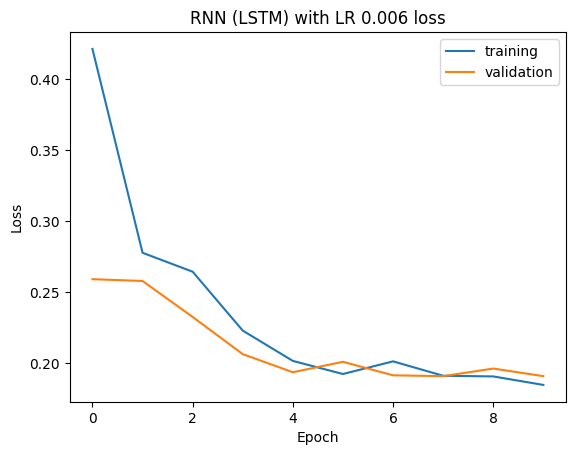

In [81]:
plot_training_loss(rnn_lr1_history, f'RNN (LSTM) with LR {learning_rate1}')

##### Using a learning rate of **0.01**

In [82]:
rnn_lr2 = RnnLR(learning_rate=learning_rate2, max_seq_length=max_seq_length, embedding_dim=100, custom_word_embedding=True)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirecti  (None, 60, 512)           731136    
 onal)                                                           
                                                                 
 dense_11 (Dense)            (None, 60, 6)             3078      
                                                                 
Total params: 734214 (2.80 MB)
Trainable params: 734214 (2.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
rnn_lr2_history = rnn_lr2.fit(
    X_train_word2fasttext,
    y_train,
    validation_data=(X_valid_word2fasttext, y_valid),
    epochs=10,
    batch_size=32
)

Epoch 1/10
34/34 [==============================] - 20s 448ms/step - loss: 0.4386 - accuracy: 0.8684 - val_loss: 0.2567 - val_accuracy: 0.9164
Epoch 2/10
34/34 [==============================] - 14s 405ms/step - loss: 0.2752 - accuracy: 0.9058 - val_loss: 0.2412 - val_accuracy: 0.9176
Epoch 3/10
34/34 [==============================] - 14s 404ms/step - loss: 0.2467 - accuracy: 0.9094 - val_loss: 0.2139 - val_accuracy: 0.9235
Epoch 4/10
34/34 [==============================] - 14s 406ms/step - loss: 0.2220 - accuracy: 0.9167 - val_loss: 0.2109 - val_accuracy: 0.9229
Epoch 5/10
34/34 [==============================] - 14s 402ms/step - loss: 0.2118 - accuracy: 0.9215 - val_loss: 0.2180 - val_accuracy: 0.9233
Epoch 6/10
34/34 [==============================] - 14s 411ms/step - loss: 0.2083 - accuracy: 0.9208 - val_loss: 0.1961 - val_accuracy: 0.9306
Epoch 7/10
34/34 [==============================] - 14s 401ms/step - loss: 0.1974 - accuracy: 0.9263 - val_loss: 0.1872 - val_accuracy: 0.9310

Training loss:



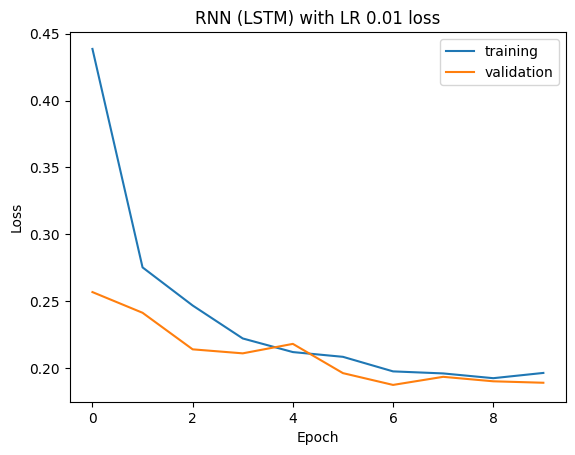

In [84]:
plot_training_loss(rnn_lr2_history, f'RNN (LSTM) with LR {learning_rate2}')

#### 2.3.1.3. Predictions and evaluation

##### Using a learning rate of **0.006**

In [85]:
rnn_lr1_pred = rnn_lr1.predict(X_test_word2fasttext)

5/5 [==============================] - 1s 98ms/step


Overall score:

	f1-score	0.9
	accuracy	0.88


Classification report:

              precision    recall  f1-score   support

          AC       0.63      0.62      0.63       265
          LF       0.34      0.36      0.35       148
           O       0.93      0.94      0.94      4148

   micro avg       0.89      0.91      0.90      4561
   macro avg       0.63      0.64      0.64      4561
weighted avg       0.89      0.91      0.90      4561


Confusion matrix:



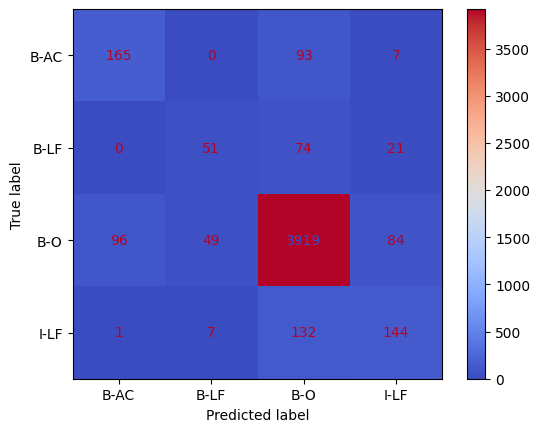

In [86]:
evaluate_model_performance(y_test, rnn_lr1_pred)

##### Using a learning rate of **0.01**

In [87]:
rnn_lr2_pred = rnn_lr2.predict(X_test_word2fasttext)

5/5 [==============================] - 1s 95ms/step


Overall score:

	f1-score	0.9
	accuracy	0.89


Classification report:

              precision    recall  f1-score   support

          AC       0.65      0.51      0.57       265
          LF       0.38      0.33      0.36       148
           O       0.92      0.97      0.94      4148

   micro avg       0.89      0.92      0.90      4561
   macro avg       0.65      0.60      0.62      4561
weighted avg       0.88      0.92      0.90      4561


Confusion matrix:



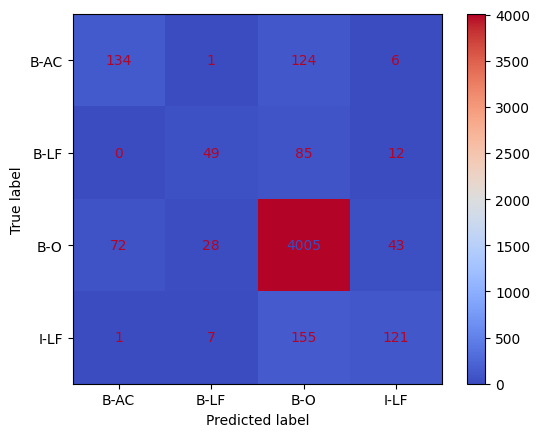

In [88]:
evaluate_model_performance(y_test, rnn_lr2_pred)

### 2.3.2. Activation functions

In [89]:
def gaussian(x: tf.Tensor) -> tf.Tensor:
  """
  Custom gaussian activation function.

  Prameters:
    x (tf.Tensor): The tensor passed to the output layer.
  Returns:
    tf.Tensor: The predicted probabilities of each class.
  """
  return tf.exp(-tf.square(x))

In [90]:
class RnnAF(RNN):
  def __init__(self, max_seq_length: int, activation_function: str="softmax", embedding_dim: int=100, custom_word_embedding: bool=False, vocab_size: int=-1):
    """
    Overriding the constructor to incorporate the activation function (AF). The AF used previously is softmax.
    """
    self.custom_word_embedding = custom_word_embedding
    self.embedding_dim = embedding_dim
    if custom_word_embedding:
      self.input_shape = (max_seq_length, self.embedding_dim)
    else:
      self.input_shape = max_seq_length
      self.vocab_size = vocab_size

    self._build(activation_function)

  def _build(self, activation_function: str) -> None:
    """
    Overriding the _build method to compile the model with a different activation function.
    """
    self.rnn_model = Sequential()
    if not self.custom_word_embedding:
      self.rnn_model.add(Embedding(self.vocab_size, self.embedding_dim, input_length=self.input_shape))
    else:
      self.rnn_model.add(Input(shape=self.input_shape))
    self.rnn_model.add((Bidirectional(LSTM(256, return_sequences=True))))
    self.rnn_model.add(Dense(6, activation=activation_function)) # passing a new activation function

    self.rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    self.rnn_model.summary()

#### 2.3.2.1. Building and training models

In [91]:
# defining our activation functions
activation_function1 = 'sigmoid'
activation_function2 = gaussian

##### Using **sigmoid** as an activation function

In [92]:
rnn_af1 = RnnAF(activation_function=activation_function1, max_seq_length=max_seq_length, embedding_dim=100, custom_word_embedding=True)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 60, 512)           731136    
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 60, 6)             3078      
                                                                 
Total params: 734214 (2.80 MB)
Trainable params: 734214 (2.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [93]:
rnn_af1_history = rnn_af1.fit(
    X_train_word2fasttext,
    y_train,
    validation_data=(X_valid_word2fasttext, y_valid),
    epochs=10,
    batch_size=32
)

Epoch 1/10
34/34 [==============================] - 19s 446ms/step - loss: 0.5063 - accuracy: 0.8549 - val_loss: 0.2796 - val_accuracy: 0.9120
Epoch 2/10
34/34 [==============================] - 14s 421ms/step - loss: 0.2951 - accuracy: 0.9048 - val_loss: 0.2559 - val_accuracy: 0.9202
Epoch 3/10
34/34 [==============================] - 14s 428ms/step - loss: 0.2568 - accuracy: 0.9079 - val_loss: 0.2313 - val_accuracy: 0.9237
Epoch 4/10
34/34 [==============================] - 15s 451ms/step - loss: 0.2282 - accuracy: 0.9155 - val_loss: 0.2116 - val_accuracy: 0.9251
Epoch 5/10
34/34 [==============================] - 15s 430ms/step - loss: 0.2105 - accuracy: 0.9226 - val_loss: 0.2025 - val_accuracy: 0.9272
Epoch 6/10
34/34 [==============================] - 15s 432ms/step - loss: 0.2052 - accuracy: 0.9247 - val_loss: 0.1968 - val_accuracy: 0.9292
Epoch 7/10
34/34 [==============================] - 15s 429ms/step - loss: 0.1968 - accuracy: 0.9267 - val_loss: 0.1914 - val_accuracy: 0.9280

Training loss:



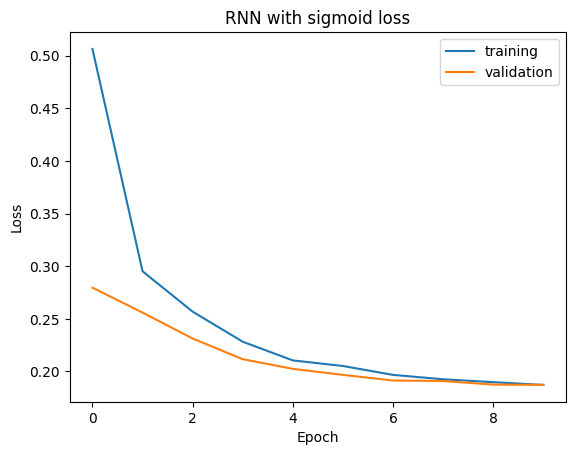

In [94]:
plot_training_loss(rnn_af1_history, 'RNN with sigmoid')

##### Using **gaussian** as an activation function

In [95]:
rnn_af2 = RnnAF(activation_function=activation_function2, max_seq_length=max_seq_length, embedding_dim=100, custom_word_embedding=True)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirecti  (None, 60, 512)           731136    
 onal)                                                           
                                                                 
 dense_13 (Dense)            (None, 60, 6)             3078      
                                                                 
Total params: 734214 (2.80 MB)
Trainable params: 734214 (2.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [96]:
rnn_af2_history = rnn_af2.fit(
    X_train_word2fasttext,
    y_train,
    validation_data=(X_valid_word2fasttext, y_valid),
    epochs=10,
    batch_size=32
)

Epoch 1/10
34/34 [==============================] - 20s 442ms/step - loss: 0.6277 - accuracy: 0.8154 - val_loss: 0.2878 - val_accuracy: 0.9115
Epoch 2/10
34/34 [==============================] - 14s 403ms/step - loss: 0.3016 - accuracy: 0.8975 - val_loss: 0.2629 - val_accuracy: 0.9120
Epoch 3/10
34/34 [==============================] - 14s 404ms/step - loss: 0.2790 - accuracy: 0.9038 - val_loss: 0.2518 - val_accuracy: 0.9185
Epoch 4/10
34/34 [==============================] - 14s 402ms/step - loss: 0.2574 - accuracy: 0.9057 - val_loss: 0.2286 - val_accuracy: 0.9210
Epoch 5/10
34/34 [==============================] - 13s 397ms/step - loss: 0.2518 - accuracy: 0.9065 - val_loss: 0.2444 - val_accuracy: 0.9201
Epoch 6/10
34/34 [==============================] - 14s 408ms/step - loss: 0.2358 - accuracy: 0.9115 - val_loss: 0.2224 - val_accuracy: 0.9209
Epoch 7/10
34/34 [==============================] - 13s 398ms/step - loss: 0.2261 - accuracy: 0.9161 - val_loss: 0.2091 - val_accuracy: 0.9245

Training loss:



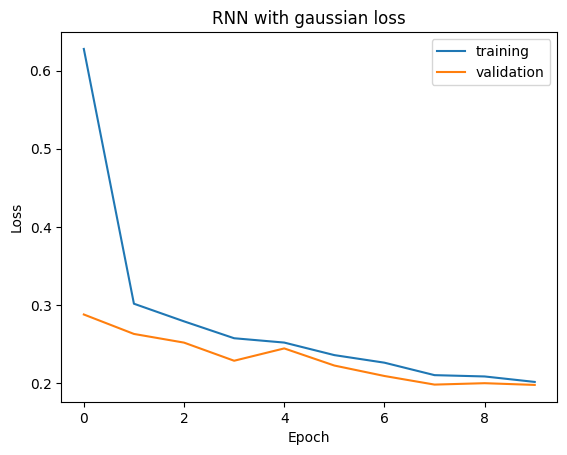

In [97]:
plot_training_loss(rnn_af2_history, 'RNN with gaussian')

#### 2.3.2.2. Predictions and evaluation

##### Using **sigmoid** as an activation function

In [98]:
rnn_af1_pred = rnn_af1.predict(X_test_word2fasttext)

5/5 [==============================] - 1s 109ms/step


Overall score:

	f1-score	0.9
	accuracy	0.88


Classification report:

              precision    recall  f1-score   support

          AC       0.65      0.57      0.60       265
          LF       0.33      0.18      0.23       148
           O       0.91      0.97      0.94      4148

   micro avg       0.88      0.92      0.90      4561
   macro avg       0.63      0.57      0.59      4561
weighted avg       0.87      0.92      0.89      4561


Confusion matrix:



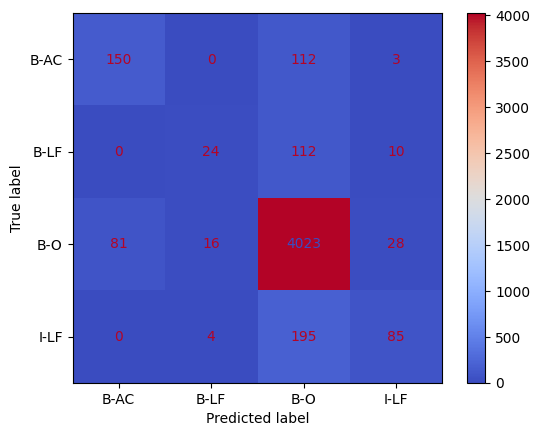

In [99]:
evaluate_model_performance(y_test, rnn_af1_pred)

##### Using **gaussian** as an activation function

In [100]:
rnn_af2_pred = rnn_af2.predict(X_test_word2fasttext)

5/5 [==============================] - 2s 186ms/step


Overall score:

	f1-score	0.89
	accuracy	0.88


Classification report:

              precision    recall  f1-score   support

          AC       0.58      0.67      0.62       265
          LF       0.28      0.33      0.30       148
           O       0.93      0.94      0.93      4148

   micro avg       0.88      0.90      0.89      4561
   macro avg       0.60      0.64      0.62      4561
weighted avg       0.89      0.90      0.89      4561


Confusion matrix:



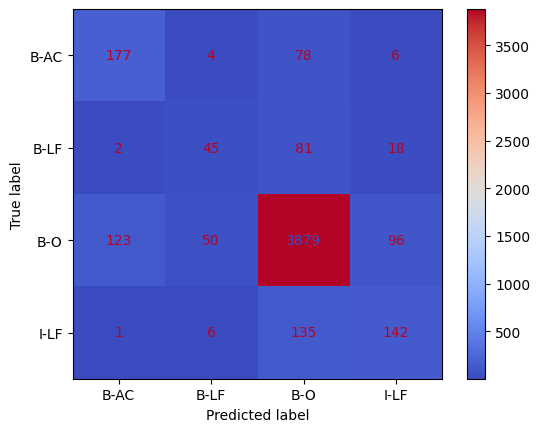

In [101]:
evaluate_model_performance(y_test, rnn_af2_pred)

### 2.3.3. Batch size

In [102]:
# defining batch sizes, note that the previous batch size used was 32
batch_size1 = 64
batch_size2 = 128

#### 2.3.3.1. Building and training models

##### Using a batch size of **64**

In [103]:
rnn_bs1 = RNN(max_seq_length=max_seq_length, embedding_dim=100, custom_word_embedding=True)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirecti  (None, 60, 512)           731136    
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 60, 6)             3078      
                                                                 
Total params: 734214 (2.80 MB)
Trainable params: 734214 (2.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [104]:
rnn_bs1_history = rnn_bs1.fit(
    X_train_word2fasttext,
    y_train,
    validation_data=(X_valid_word2fasttext, y_valid),
    epochs=10,
    batch_size=batch_size1 # batch size 64
)

Epoch 1/10
17/17 [==============================] - 15s 678ms/step - loss: 0.5716 - accuracy: 0.8439 - val_loss: 0.3143 - val_accuracy: 0.9115
Epoch 2/10
17/17 [==============================] - 10s 609ms/step - loss: 0.3270 - accuracy: 0.8963 - val_loss: 0.2791 - val_accuracy: 0.9118
Epoch 3/10
17/17 [==============================] - 11s 656ms/step - loss: 0.2954 - accuracy: 0.9023 - val_loss: 0.2757 - val_accuracy: 0.9183
Epoch 4/10
17/17 [==============================] - 10s 608ms/step - loss: 0.2790 - accuracy: 0.9063 - val_loss: 0.2548 - val_accuracy: 0.9197
Epoch 5/10
17/17 [==============================] - 11s 607ms/step - loss: 0.2587 - accuracy: 0.9067 - val_loss: 0.2359 - val_accuracy: 0.9218
Epoch 6/10
17/17 [==============================] - 10s 618ms/step - loss: 0.2425 - accuracy: 0.9095 - val_loss: 0.2270 - val_accuracy: 0.9213
Epoch 7/10
17/17 [==============================] - 11s 644ms/step - loss: 0.2280 - accuracy: 0.9139 - val_loss: 0.2158 - val_accuracy: 0.9253

Training loss:



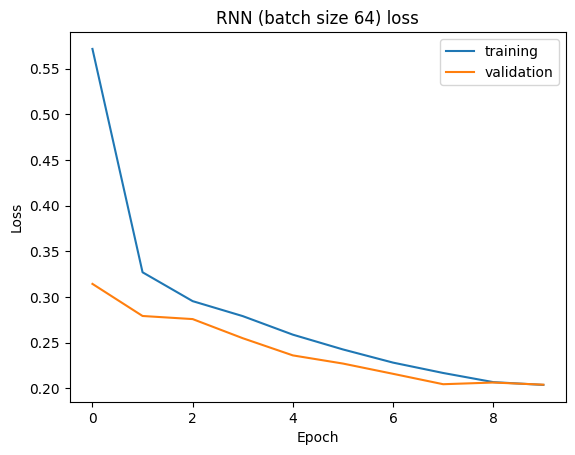

In [105]:
plot_training_loss(rnn_bs1_history, f'RNN (batch size {batch_size1})')

##### Using a batch size of **128**

In [106]:
rnn_bs2 = RNN(max_seq_length=max_seq_length, embedding_dim=100, custom_word_embedding=True)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirecti  (None, 60, 512)           731136    
 onal)                                                           
                                                                 
 dense_15 (Dense)            (None, 60, 6)             3078      
                                                                 
Total params: 734214 (2.80 MB)
Trainable params: 734214 (2.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [107]:
rnn_bs2_history = rnn_bs2.fit(
    X_train_word2fasttext,
    y_train,
    validation_data=(X_valid_word2fasttext, y_valid),
    epochs=10,
    batch_size=batch_size2 # batch size 128
)

Epoch 1/10
9/9 [==============================] - 14s 1s/step - loss: 0.9314 - accuracy: 0.7337 - val_loss: 0.4114 - val_accuracy: 0.9115
Epoch 2/10
9/9 [==============================] - 7s 806ms/step - loss: 0.3860 - accuracy: 0.8961 - val_loss: 0.3137 - val_accuracy: 0.9115
Epoch 3/10
9/9 [==============================] - 8s 958ms/step - loss: 0.3340 - accuracy: 0.8961 - val_loss: 0.2878 - val_accuracy: 0.9115
Epoch 4/10
9/9 [==============================] - 8s 937ms/step - loss: 0.3134 - accuracy: 0.8961 - val_loss: 0.2762 - val_accuracy: 0.9132
Epoch 5/10
9/9 [==============================] - 8s 812ms/step - loss: 0.2978 - accuracy: 0.9029 - val_loss: 0.2678 - val_accuracy: 0.9208
Epoch 6/10
9/9 [==============================] - 8s 954ms/step - loss: 0.2879 - accuracy: 0.9061 - val_loss: 0.2635 - val_accuracy: 0.9192
Epoch 7/10
9/9 [==============================] - 7s 799ms/step - loss: 0.2786 - accuracy: 0.9067 - val_loss: 0.2527 - val_accuracy: 0.9209
Epoch 8/10
9/9 [======

Training loss:



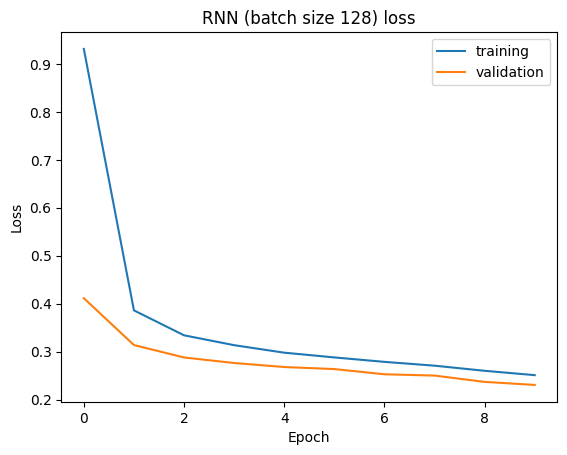

In [108]:
plot_training_loss(rnn_bs2_history, f'RNN (batch size {batch_size2})')

#### 2.3.3.2. Predictions and evaluation

##### Using a batch size of **64**

In [109]:
rnn_bs1_pred = rnn_bs1.predict(X_test_word2fasttext)

5/5 [==============================] - 1s 113ms/step


Overall score:

	f1-score	0.89
	accuracy	0.87


Classification report:

              precision    recall  f1-score   support

          AC       0.66      0.42      0.51       265
          LF       0.18      0.07      0.10       148
           O       0.89      0.98      0.93      4148

   micro avg       0.87      0.92      0.89      4561
   macro avg       0.58      0.49      0.51      4561
weighted avg       0.85      0.92      0.88      4561


Confusion matrix:



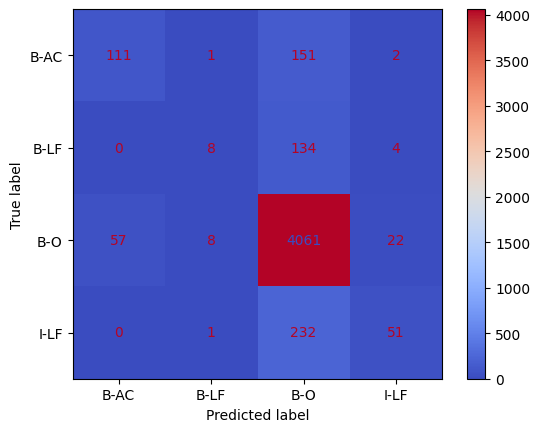

In [110]:
evaluate_model_performance(y_test, rnn_bs1_pred)

##### Using a batch size of **128**

In [111]:
rnn_bs2_pred = rnn_bs2.predict(X_test_word2fasttext)

5/5 [==============================] - 1s 97ms/step


Overall score:

	f1-score	0.89
	accuracy	0.86


Classification report:

              precision    recall  f1-score   support

          AC       0.59      0.52      0.55       265
          LF       0.00      0.00      0.00       148
           O       0.88      0.97      0.93      4148

   micro avg       0.86      0.92      0.89      4561
   macro avg       0.49      0.50      0.49      4561
weighted avg       0.84      0.92      0.87      4561


Confusion matrix:



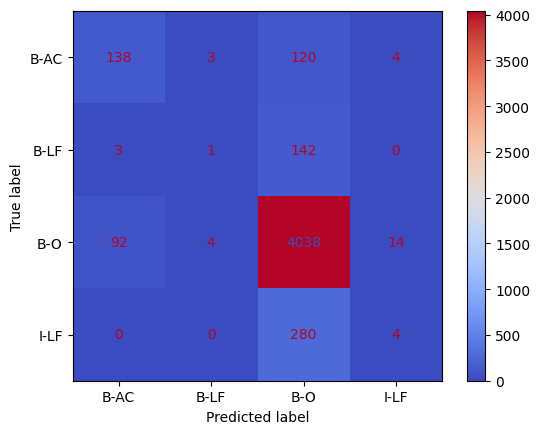

In [112]:
evaluate_model_performance(y_test, rnn_bs2_pred)

## 2.4. Experiment 4 - Using additional dataset with the best performing systems

### 2.4.1. Preparing the dataset and visualising it

In [113]:
# loading the filtered dataset to extract additional data
add_data = load_dataset("surrey-nlp/PLOD-filtered")

Generating train split:   0%|          | 0/112652 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/24140 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/24140 [00:00<?, ? examples/s]

In [114]:
# storing all the data loaded in dataframes
df_add_train = pd.DataFrame(add_data["train"])
df_add_valid = pd.DataFrame(add_data["validation"])

In [115]:
# extracting 25k samples for training and validation
data_num = 25000

# splitting the data split ratio
train_num = int(data_num * 0.8)
valid_num = int(data_num * 0.2)

In [116]:
# applying the defined ratios
df_add_train = df_add_train[:train_num]
df_add_valid = df_add_valid[:valid_num]

In [117]:
# concatenating train, valid, and test dataframes to vectorise the token sequences using FastText
df_add = pd.concat(
    [
      df_add_train.copy(),
      df_add_valid.copy(),
      df_test.copy(),
    ],
    ignore_index=True
)

In [118]:
# by checking the train dataframe we can notice that we have a new column id
df_add_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        20000 non-null  object
 1   tokens    20000 non-null  object
 2   pos_tags  20000 non-null  object
 3   ner_tags  20000 non-null  object
dtypes: object(4)
memory usage: 625.1+ KB


In [119]:
# label vectors are already numerical
df_add_train.head()

,id,tokens,pos_tags,ner_tags
0,0,"[Alternatively, ,, fibroblasts, were, plated, ...","[2, 13, 8, 3, 16, 2, 14, 14, 11, 3, 10, 16, 6,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[Study, -, specific, risk, ratios, (, RRs, ), ...","[8, 13, 0, 8, 8, 13, 12, 13, 5, 0, 12, 8, 3, 1...","[0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ..."
2,2,"[Three, faba, bean, genotypes, ,, Aguadulce, (...","[9, 8, 8, 8, 13, 12, 13, 12, 13, 13, 12, 12, 1...","[0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
3,3,"[Neurological, complications, of, cancer, incl...","[0, 8, 1, 8, 16, 0, 8, 8, 5, 8, 13, 0, 0, 8, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[Reference, values, (, RVs, ), of, each, analy...","[8, 8, 13, 12, 13, 1, 6, 8, 3, 16, 1, 6, 0, 8,...","[3, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


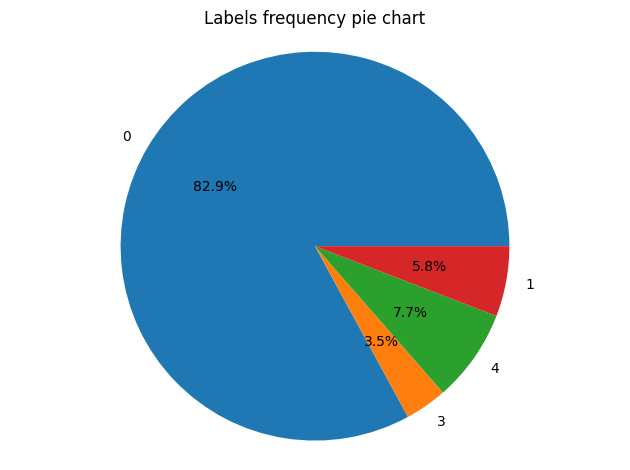

In [147]:
# labels frequency pie chart
labels_counts = Counter([y for seq in df_add_train["ner_tags"].to_numpy() for y in seq])
labels = list(labels_counts.keys())
counts = list(labels_counts.values())
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Labels frequency pie chart')
plt.axis('equal')
plt.tight_layout()

Correlation matrix heatmap

### 2.4.2. Sequences vectorisation

In [120]:
# to train the FastText model and generate the word embeddings we take the same approach.
# in the additional dataframe, tokens are in the second column.
corpus_add = [[word for word in sentence] for sentence in df_add.to_numpy()[:, 1]]
words_add = set([word for sentence in corpus_add for word in sentence])
fasttext = dict.fromkeys(words_add, 0)

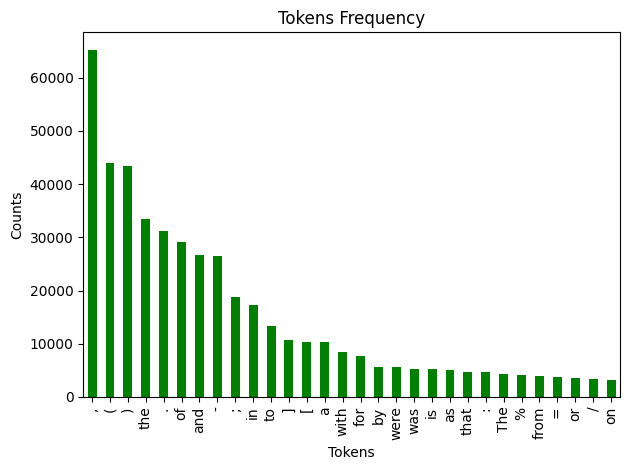

In [148]:
# tokens frequency bar chart
df_tokens = pd.DataFrame({'tokens': [token for seq in corpus_add for token in seq]})
top_thirty_tokens = df_tokens['tokens'].value_counts()[:30]
top_thirty_tokens.plot(kind='bar', color='green')
plt.title("Tokens Frequency")
plt.xlabel("Tokens")
plt.ylabel("Counts")
plt.tight_layout()

In [121]:
# training the fasttext model
fasttext_model = FastText(
    corpus_add,
    min_count=1,
    workers=4
)
# assigning the tokens their respective vectors
for word in fasttext.keys():
  fasttext[word] = fasttext_model.wv[word]

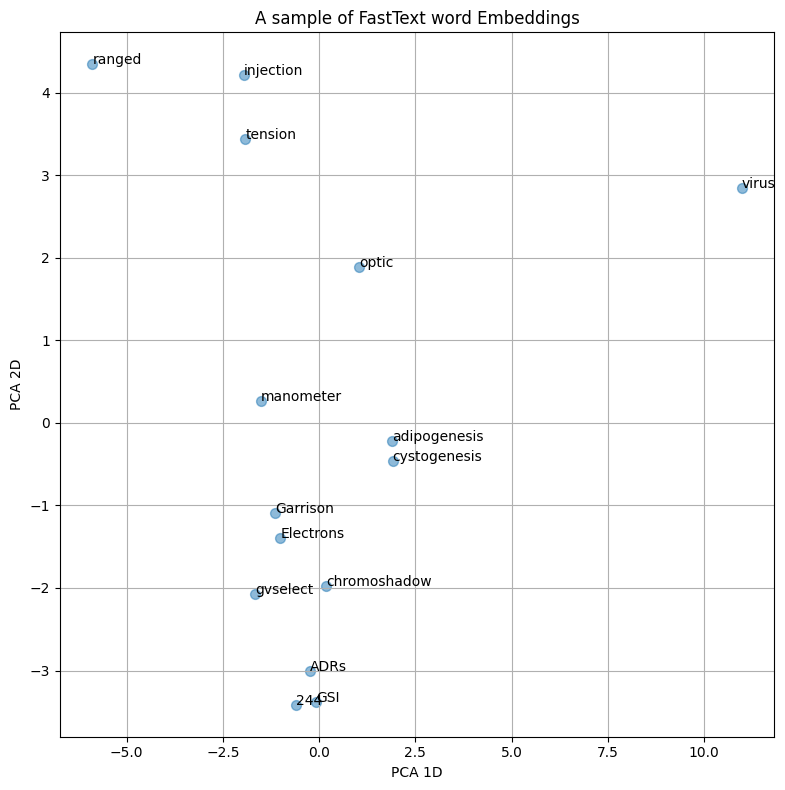

In [151]:
plot_word_embeddings(fasttext, 'FastText', 15)

In [122]:
# creating dataframes with our FastText word embeddings
df_add_train_fasttext = df_add_train.copy()
df_add_valid_fasttext = df_add_valid.copy()
df_add_test_fasttext = df_test.copy()

df_add_train_fasttext['tokens'] = df_add_train_fasttext['tokens'].apply(
    lambda tokens_arr: [fasttext[token] for token in tokens_arr]
)
df_add_valid_fasttext['tokens'] = df_add_valid_fasttext['tokens'].apply(
    lambda tokens_arr: [fasttext[token] for token in tokens_arr]
)
df_add_test_fasttext['tokens'] = df_add_test_fasttext['tokens'].apply(
    lambda tokens_arr: [fasttext[token] for token in tokens_arr]
)

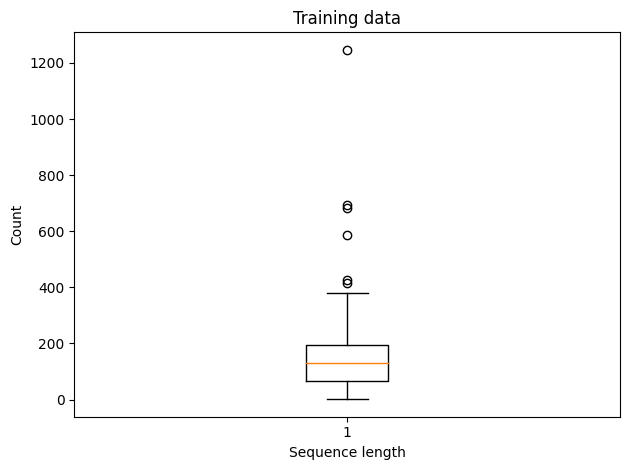

In [123]:
# plotting the sequence lengths to visualise the average length
plt.boxplot(df_add_train["tokens"].apply(lambda x: len(x)).unique())
plt.title("Training data")
plt.xlabel("Sequence length")
plt.ylabel("Count")
plt.tight_layout()

In [124]:
# computing the average sequence length to truncate our vectors.
max_seq_length = math.ceil(df_add_train["tokens"].apply(lambda x: len(x)).unique().mean())
vocab_size = len(words_add)

In [125]:
# creating feature vectors
X_add_train_fasttext = generate_feature_vectors(df_add_train_fasttext)
X_add_valid_fasttext = generate_feature_vectors(df_add_valid_fasttext)
X_add_test_fasttext = generate_feature_vectors(df_add_test_fasttext)

In [126]:
# creating label vectors
y_add_train = pad_sequences(df_add_train['ner_tags'], maxlen=max_seq_length, padding='post', value=5)
y_add_valid = pad_sequences(df_add_valid['ner_tags'], maxlen=max_seq_length, padding='post', value=5)
y_add_test = pad_sequences(df_test['ner_tags'], maxlen=max_seq_length, padding='post', value=5)

### 2.4.3. Building, training, and evaluating the best performing models from our previous systems with the additional data - RNN & CNN

#### 2.4.3.1. RNN (LSTM)

##### Building the **RNN** model

In [127]:
rnn2 = RNN(max_seq_length=max_seq_length, embedding_dim=100, custom_word_embedding=True)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirect  (None, 148, 512)          731136    
 ional)                                                          
                                                                 
 dense_16 (Dense)            (None, 148, 6)            3078      
                                                                 
Total params: 734214 (2.80 MB)
Trainable params: 734214 (2.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Training the **RNN** model

In [128]:
rnn2_history = rnn2.fit(
    X_add_train_fasttext,
    y_add_train,
    validation_data=(X_add_valid_fasttext, y_add_valid),
    epochs=10,
    batch_size=32
)

Epoch 1/10
625/625 [==============================] - 600s 952ms/step - loss: 0.0775 - accuracy: 0.9722 - val_loss: 0.0595 - val_accuracy: 0.9760
Epoch 2/10
625/625 [==============================] - 639s 1s/step - loss: 0.0560 - accuracy: 0.9778 - val_loss: 0.0548 - val_accuracy: 0.9785
Epoch 3/10
625/625 [==============================] - 671s 1s/step - loss: 0.0518 - accuracy: 0.9794 - val_loss: 0.0511 - val_accuracy: 0.9798
Epoch 4/10
625/625 [==============================] - 658s 1s/step - loss: 0.0493 - accuracy: 0.9804 - val_loss: 0.0506 - val_accuracy: 0.9804
Epoch 5/10
625/625 [==============================] - 585s 936ms/step - loss: 0.0469 - accuracy: 0.9813 - val_loss: 0.0491 - val_accuracy: 0.9804
Epoch 6/10
625/625 [==============================] - 609s 974ms/step - loss: 0.0447 - accuracy: 0.9822 - val_loss: 0.0491 - val_accuracy: 0.9807
Epoch 7/10
625/625 [==============================] - 642s 1s/step - loss: 0.0430 - accuracy: 0.9828 - val_loss: 0.0484 - val_accurac

##### Plotting the **RNN** training loss

Training loss:



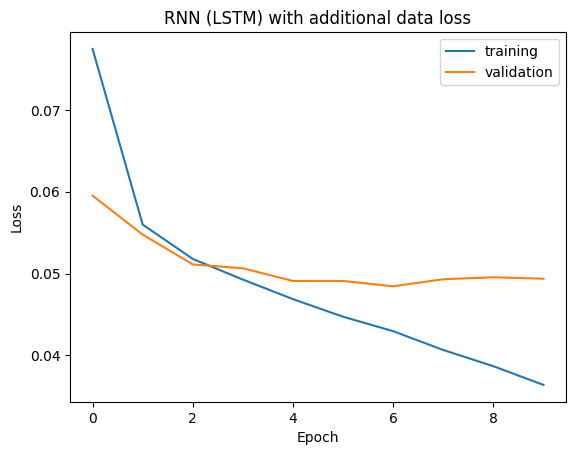

In [129]:
plot_training_loss(rnn2_history, 'RNN (LSTM) with additional data')

##### Predicting on unseen data

In [130]:
rnn2_pred = rnn2.predict(X_add_test_fasttext)

5/5 [==============================] - 2s 243ms/step


In [131]:
def compare_random_sample_prediction(y_pred: np.array) -> None:
  """
  Displays the prediction of classes for a random sample of features, and its respective true classes.

  Parameters:
    y_pred (np.array): An array of predicted classes.
  """
  sample_num = random.randint(0, len(y_add_test))
  print(f'Prediced classes for sample {sample_num}:\n', y_pred[sample_num])
  print()
  print(f'True classes for sample {sample_num}:\n', y_add_test[sample_num])

In [134]:
compare_random_sample_prediction(rnn2_pred)

Prediced classes for sample 52:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 4 4 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]

True classes for sample 52:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 4 4 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


##### Evaluating the **RNN** performance

Overall score:

	f1-score	0.95
	accuracy	0.94


Classification report:

              precision    recall  f1-score   support

          AC       0.75      0.84      0.79       270
          LF       0.64      0.71      0.67       152
           O       0.98      0.96      0.97      4292

   micro avg       0.95      0.95      0.95      4714
   macro avg       0.79      0.84      0.81      4714
weighted avg       0.95      0.95      0.95      4714


Confusion matrix:



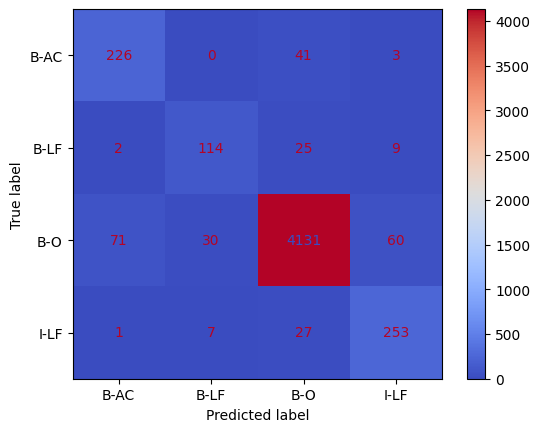

In [133]:
evaluate_model_performance(y_add_test, rnn2_pred)

#### 2.4.3.2. CNN

##### Building the **CNN** model

In [135]:
cnn2 = CNN(max_seq_length=max_seq_length, embedding_dim=100, custom_word_embedding=True)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 148, 128)          38528     
                                                                 
 conv1d_5 (Conv1D)           (None, 148, 128)          49280     
                                                                 
 conv1d_6 (Conv1D)           (None, 148, 128)          49280     
                                                                 
 conv1d_7 (Conv1D)           (None, 148, 128)          49280     
                                                                 
 dense_17 (Dense)            (None, 148, 6)            774       
                                                                 
Total params: 187142 (731.02 KB)
Trainable params: 187142 (731.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Training the **CNN** model

In [136]:
cnn2_history = cnn2.fit(
    X_add_train_fasttext,
    y_add_train,
    validation_data=(X_add_valid_fasttext, y_add_valid),
    epochs=4,
    batch_size=32
)

Epoch 1/4
625/625 [==============================] - 87s 137ms/step - loss: 82.2044 - accuracy: 0.9591 - val_loss: 4.9872 - val_accuracy: 0.9665
Epoch 2/4
625/625 [==============================] - 86s 137ms/step - loss: 1.6697 - accuracy: 0.9657 - val_loss: 1.4475 - val_accuracy: 0.9673
Epoch 3/4
625/625 [==============================] - 87s 139ms/step - loss: 0.6073 - accuracy: 0.9683 - val_loss: 0.1404 - val_accuracy: 0.9712
Epoch 4/4
625/625 [==============================] - 84s 135ms/step - loss: 0.2266 - accuracy: 0.9704 - val_loss: 0.1773 - val_accuracy: 0.9728


##### Plotting the **CNN** training loss

Training loss:



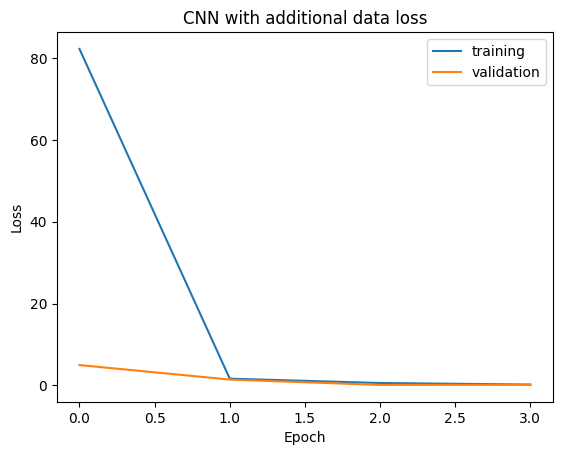

In [137]:
plot_training_loss(cnn2_history, 'CNN with additional data')

##### Predicting on unseen data

In [138]:
cnn2_pred = cnn2.predict(X_add_test_fasttext)

5/5 [==============================] - 0s 35ms/step


In [139]:
compare_random_sample_prediction(cnn2_pred)

Prediced classes for sample 132:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 4 4 4 0 1 0 0 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]

True classes for sample 132:
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 4 4 4 0 1 0 0 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


##### Evaluating the **CNN** model performance

Overall score:

	f1-score	0.93
	accuracy	0.93


Classification report:

              precision    recall  f1-score   support

          AC       0.77      0.61      0.68       270
          LF       0.42      0.54      0.48       152
           O       0.96      0.97      0.96      4292

   micro avg       0.93      0.93      0.93      4714
   macro avg       0.72      0.71      0.71      4714
weighted avg       0.93      0.93      0.93      4714


Confusion matrix:



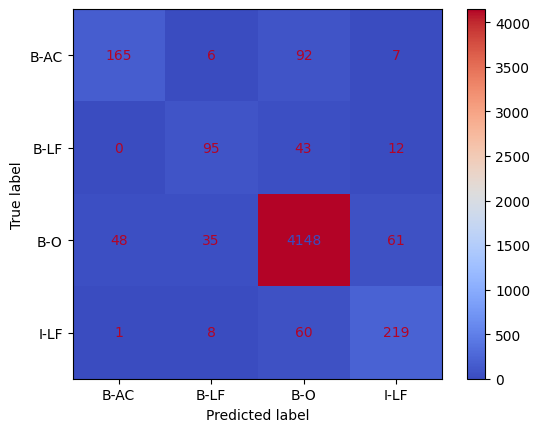

In [140]:
evaluate_model_performance(y_add_test, cnn2_pred)